In [43]:
# Standard library imports
import os
import json
import time
import pickle
import logging
import warnings
from pathlib import Path
from datetime import datetime, timezone, timedelta
from concurrent.futures import ProcessPoolExecutor, as_completed
from collections import defaultdict
from typing import List, Optional, Union

# Third party imports
import numpy as np
import pandas as pd
import dask.dataframe as dd
import requests
import pytz
from dotenv import load_dotenv
from tqdm import tqdm
from numba import jit

# Geospatial
import geopandas as gpd
import dask_geopandas
import h3
from shapely.geometry import Polygon

# Scientific and astronomical
from skyfield.api import load, EarthSatellite
from skyfield.api import wgs84
from skyfield.framelib import itrs
import pymsis
from pymsis import msis
from statistics import mean

import spacetrack.operators as op
from spacetrack import SpaceTrackClient

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.collections import LineCollection
from matplotlib.dates import DateFormatter
from matplotlib.gridspec import GridSpec

# Mapping and projections
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Statistics
from statsmodels.nonparametric.smoothers_lowess import lowess

# Configuration
warnings.filterwarnings("ignore")
plt.rcParams.update({
   'font.family': 'serif',
   'font.serif': ['Times New Roman'] + plt.rcParams['font.serif']
})

# Environment setup
load_dotenv()
username = os.getenv('SPACETRACK_USERNAME')
password = os.getenv('SPACETRACK_PASSWORD')

In [36]:
def fetch_satellite_tles(category="starlink"):
    """
    Fetch satellite IDs and TLEs from CelesTrak for a given category.
    
    Args:
        category (str): Satellite category (default: "starlink")
    Returns:
        list: List of dictionaries with satellite IDs and TLE data
    """
    base_url = "https://celestrak.org/NORAD/elements/gp.php"
    params = {"GROUP": category, "FORMAT": "json"}
    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        response.raise_for_status()

try:
    tles = fetch_satellite_tles(category="noaa")
except Exception as e:
    print(f"Error: {e}")
starlink_ids = [tle['NORAD_CAT_ID'] for tle in tles]

In [37]:
def get_bulk_satellite_tles(satellite_type, username, password,
                            start_date=None, end_date=None, retries=5, delay=5):
    """
    Fetch bulk TLE data using the Space-Track API.
    
    Uses gp_history for historical data (with an epoch range) and gp for current data.
    Implements simple retry logic to handle read timeouts.
    
    Args:
        satellite_type (str): Target satellite pattern (e.g., "STARLINK").
        username (str): Space-Track API username.
        password (str): Space-Track API password.
        start_date (datetime, optional): Start date for historical TLE data.
        end_date (datetime, optional): End date for historical TLE data.
        retries (int, optional): Number of retry attempts on timeout.
        delay (int, optional): Seconds to wait between retries.
    
    Returns:
        list: List of TLE lines as strings.
    """
    for attempt in range(retries):
        try:
            with SpaceTrackClient(identity=username, password=password) as st:
                if start_date and end_date:
                    epoch_range = f"{start_date.strftime('%Y-%m-%d')}--{end_date.strftime('%Y-%m-%d')}"
                    # Use gp_history for historical data.
                    tle = st.gp_history(
                        object_name=op.like(satellite_type),
                        epoch=epoch_range,
                        orderby="epoch asc",
                        format="tle"
                    )
                else:
                    # Use gp for current active satellites.
                    tle = st.gp(
                        object_name=op.like(satellite_type),
                        decay_date="null-val",
                        orderby="epoch desc",
                        format="tle"
                    )
            return tle
        except httpx.ReadTimeout as e:
            if attempt < retries - 1:
                print(f"ReadTimeout occurred, retrying in {delay} seconds (attempt {attempt + 1})...")
                time.sleep(delay)
            else:
                raise e
    return ''

# For historical data:
storm_start = datetime(2024, 5, 9)
storm_end = datetime(2024, 5, 13)

In [38]:
# historical_tles = get_bulk_satellite_tles('STARLINK', username, password, 
#                                             start_date=storm_start, 
#                                             end_date=storm_end)

In [39]:
# Fetch Starlink NORAD IDs (replace 'STARLINK%' if specific IDs are known)
starlink_query = ("https://www.space-track.org/basicspacedata/query/class/satcat/"
                  "object_name/STARLINK%/CURRENT/Y/orderby/LAUNCH_DATE desc/format/json")

# If no TLEs found in time range, fetch latest TLE
with requests.Session() as session:
    login_url = "https://www.space-track.org/ajaxauth/login"
    auth_data = {"identity": username, "password": password}
    session = requests.Session()
    login_response = session.post(login_url, data=auth_data)
    
    if login_response.status_code != 200:
        raise ValueError("Login failed. Check credentials.")

In [40]:
def fetch_tle_data(norad_id, username, password, start_date=None, end_date=None):
    """
    Fetch TLE data from Space-Track API for specific NORAD ID.

    Args:
        norad_id: Satellite NORAD catalog ID
        username: Space-Track login credentials
        password: Space-Track login credentials
        start_date: Optional date range start for historical data
        end_date: Optional date range end for historical data
    
    Returns:
        str: Raw TLE data in standard format from Space-Track
    """
    base_url = "https://www.space-track.org"
    login_url = f"{base_url}/ajaxauth/login"
    
    # If no TLEs found in time range, fetch latest TLE
    with requests.Session() as session:
        session.post(login_url, data={"identity": username, "password": password})
        if start_date and end_date and start_date.date() == end_date.date():
            date = start_date.date().isoformat()
            query_url = (f"{base_url}/basicspacedata/query/class/tle/"
                        f"norad_cat_id/{norad_id}/EPOCH/{date}/"
                        "orderby/EPOCH asc/format/tle")
        elif start_date and end_date:
            query_url = (f"{base_url}/basicspacedata/query/class/tle/"
                        f"norad_cat_id/{norad_id}/EPOCH/{start_date.isoformat()}--{end_date.isoformat()}/"
                        "orderby/EPOCH asc/format/tle")
        else:
            query_url = (f"{base_url}/basicspacedata/query/class/tle_latest/"
                        f"norad_cat_id/{norad_id}/orderby/EPOCH desc/limit/1/format/tle")
        response = session.get(query_url).text
        
        # If no TLEs found, get latest
        if not response.strip():
            query_url = (f"{base_url}/basicspacedata/query/class/tle_latest/"
                        f"norad_cat_id/{norad_id}/orderby/EPOCH desc/limit/1/format/tle")
            response = session.get(query_url).text
        return response

In [7]:
def organize_tle_data(tle_string):
    """
    Organize raw TLE string data into a structured dictionary format.

    Args:
        tle_string: Multi-line string containing TLE data sets
    
    Returns:
        dict: Satellite data organized as:
            {
                sat_id: {
                    'name': satellite name,
                    'tles': [
                        {
                            'epoch': datetime of TLE,
                            'line1': first line of TLE,
                            'line2': second line of TLE
                        }
                    ]
                }
            }
    """
    # Split into lines and remove empty lines
    lines = [line.strip() for line in tle_string.split('\n') if line.strip()]
    
    # Dictionary to store organized data
    satellites = {}
    
    # Process lines in pairs
    for i in range(0, len(lines), 2):
        if i + 1 >= len(lines):  # Skip incomplete pairs
            break
            
        line1 = lines[i]
        line2 = lines[i + 1]
        
        # Extract satellite ID and name from Line 1
        # Line 1 format: 1 NNNNNC NNNNNAAA NNNNN.NNNNNNNN +.NNNNNNNN +NNNNN-N +NNNNN-N N NNNNN
        sat_id = line1[2:7].strip()  # NORAD Catalog Number
        
        # Extract epoch from Line 1
        year = int("20" + line1[18:20])
        day_of_year = float(line1[20:32])
        epoch = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
        
        # If this is a new satellite, initialize its entry
        if sat_id not in satellites:
            satellites[sat_id] = {
                'name': f"STARLINK-{sat_id}",
                'tles': []
            }
        
        # Add this TLE set to the satellite's data
        tle_data = {
            'epoch': epoch,
            'line1': line1,
            'line2': line2
        }
        satellites[sat_id]['tles'].append(tle_data)
    
    # Sort TLEs by epoch for each satellite
    for sat_id in satellites:
        satellites[sat_id]['tles'].sort(key=lambda x: x['epoch'])
    
    return satellites

In [8]:
def process_and_save_satellite_data(username, password, storm_start, storm_end):
    """
    Fetch, process and save satellite TLE data to a pickle file.

    Args:
        username: Space-Track login credentials
        password: Space-Track login credentials
        storm_start: Start date for historical data
        storm_end: End date for historical data
    
    Returns:
        tuple: Contains (historical_tles, current_tles, tle_data, 
               tle_data_zarya, starlink_gannon, starlink_current)
    """
    print("Fetching hist data...")
    # Fetch historical Starlink data
    historical_tles = get_bulk_satellite_tles('STARLINK', username, password, 
                                            start_date=storm_start, 
                                            end_date=storm_end)

    print("Fetching current data...")
    # Fetch current Starlink data
    current_tles = get_bulk_satellite_tles('STARLINK', username, password)

    print("Fetching ISS data...")
    # Fetch ISS (Zarya) data
    tle_data_zarya = fetch_tle_data(
        25544,
        username,
        password,
        storm_start,
        storm_end
    )
    
    # Organize TLE data
    starlink_gannon = organize_tle_data(historical_tles)
    starlink_current = organize_tle_data(current_tles)
    
    # Prepare data dictionary for saving
    satellite_data = {
        'historical_tles': historical_tles,
        'current_tles': current_tles,
        'tle_data_zarya': tle_data_zarya,
        'starlink_gannon': starlink_gannon,
        'starlink_current': starlink_current
    }
    
    # Save to pickle file
    with open('satellite_data.pkl', 'wb') as f:
        pickle.dump(satellite_data, f)
        
    return (historical_tles, current_tles, tle_data_zarya, starlink_gannon, starlink_current)

def load_satellite_data():
    """
    Load satellite data from pickle file.

    Returns:
        tuple: Contains (historical_tles, current_tles, tle_data, 
               tle_data_zarya, starlink_gannon, starlink_current)
    """
    with open('satellite_data.pkl', 'rb') as f:
        data = pickle.load(f)
        return (data['historical_tles'], data['current_tles'],  data['tle_data_zarya'], 
                data['starlink_gannon'], data['starlink_current'])

# Main execution
if os.path.exists('satellite_data.pkl'):
    # Load and unpack existing data
    (historical_tles, current_tles, tle_data_zarya, starlink_gannon, starlink_current) = load_satellite_data()
else:
    print("File doesn't exist")
    # Process, save, and unpack new data
    (historical_tles, current_tles, tle_data_zarya, starlink_gannon, starlink_current) = process_and_save_satellite_data(
         username, password, storm_start, storm_end)

In [49]:
def preprocess_tle_data(sat_data, ts, window_start, window_end):
   """Preprocess TLE data for a satellite"""
   tle_with_epochs = []
   
   # Process each TLE once
   for tle in sat_data['tles']:
       sat = EarthSatellite(tle['line1'], tle['line2'], sat_data['name'], ts)
       epoch = sat.epoch.utc_datetime()
       if not epoch.tzinfo:
           epoch = pytz.UTC.localize(epoch)
       tle_with_epochs.append({
           'epoch': epoch,
           'sat_obj': sat
       })
   
   # Sort and create validity intervals
   sorted_tles = sorted(tle_with_epochs, key=lambda x: x['epoch'])
   tle_intervals = []
   
   for i, tle in enumerate(sorted_tles[:-1]):
       tle_intervals.append((tle['epoch'], sorted_tles[i+1]['epoch'], tle))
   if sorted_tles:
       tle_intervals.append((sorted_tles[-1]['epoch'], window_end, sorted_tles[-1]))
       
   return sorted_tles, tle_intervals

def find_valid_tle(time, tle_intervals, sorted_tles):
   """Binary search for valid TLE"""
   left, right = 0, len(tle_intervals)
   while left < right:
       mid = (left + right) // 2
       interval = tle_intervals[mid]
       if interval[0] <= time < interval[1]:
           return interval[2]
       elif time < interval[0]:
           right = mid
       else:
           left = mid + 1
   return sorted_tles[0] if sorted_tles else None

def process_satellite(sat_id, sat_data, time_steps, ts, window_start, window_end):
    """Process single satellite data with added velocities and Cartesian coordinates"""
    # Pre-compute time objects
    ts_times = [ts.utc(
        t.year, t.month, t.day,
        t.hour, t.minute, t.second
    ) for t in time_steps]
    
    # Initialize arrays for better performance
    n_steps = len(time_steps)
    latitudes = np.zeros(n_steps)
    longitudes = np.zeros(n_steps)
    altitudes = np.zeros(n_steps)
    velocities = {'vx': np.zeros(n_steps), 'vy': np.zeros(n_steps), 'vz': np.zeros(n_steps)}
    cartesian_positions = {'x': np.zeros(n_steps), 'y': np.zeros(n_steps), 'z': np.zeros(n_steps)}
    valid_indices = []
    
    # Preprocess TLE data
    sorted_tles, tle_intervals = preprocess_tle_data(sat_data, ts, window_start, window_end)
    
    # Process each timestep
    for i, (t, ts_time) in enumerate(zip(time_steps, ts_times)):
        valid_tle = find_valid_tle(t, tle_intervals, sorted_tles)
        
        if valid_tle:
            sat_obj = valid_tle['sat_obj']
            position = sat_obj.at(ts_time)
            subpoint = position.subpoint()
            
            # Geodetic (lat, lon, alt)
            latitudes[i] = subpoint.latitude.degrees
            longitudes[i] = subpoint.longitude.degrees
            altitudes[i] = subpoint.elevation.km
            
            # Convert to Earth-fixed (ECEF) frame for drag calculations
            itrs_pos = position.frame_xyz(itrs)
            x_ecef, y_ecef, z_ecef = itrs_pos.km
            x, y, z = x_ecef * 1000., y_ecef * 1000., z_ecef * 1000.  # m
            
            # Cartesian (x, y, z) in km
            cartesian = position.position.km
            cartesian_positions['x'][i] = x
            cartesian_positions['y'][i] = y
            cartesian_positions['z'][i] = z

            # Use ECEF velocities (in km/s), converted to m/s
            itrs_vel = position.velocity(itrs)
            vx_ecef, vy_ecef, vz_ecef = itrs_vel.km_per_s
            vx, vy, vz = vx_ecef * 1000., vy_ecef * 1000., vz_ecef * 1000.
            
            # Velocities (vx, vy, vz) in km/s
            velocity = position.velocity.km_per_s
            velocities['vx'][i] = vx
            velocities['vy'][i] = vy
            velocities['vz'][i] = vz
            
            valid_indices.append(i)
    
    # Trim arrays to valid indices
    valid_indices = np.array(valid_indices)
    if len(valid_indices) > 0:
        latitudes = latitudes[valid_indices]
        longitudes = longitudes[valid_indices]
        altitudes = altitudes[valid_indices]
        times = [time_steps[i] for i in valid_indices]
        
        for key in velocities:
            velocities[key] = velocities[key][valid_indices].tolist()
        for key in cartesian_positions:
            cartesian_positions[key] = cartesian_positions[key][valid_indices].tolist()
    else:
        latitudes = longitudes = altitudes = np.array([])
        times = []
        velocities = {k: [] for k in velocities}
        cartesian_positions = {k: [] for k in cartesian_positions}
    
    return sat_id, {
        'name': sat_data['name'],
        'times': times,
        'latitudes': latitudes.tolist(),
        'longitudes': longitudes.tolist(),
        'altitudes': altitudes.tolist(),
        'velocities': velocities,
        'cartesian_positions': cartesian_positions,
        'mean_altitude': np.nanmean(altitudes) if len(altitudes) > 0 else None,
        'median_altitude': np.nanmedian(altitudes) if len(altitudes) > 0 else None,
        'altitude_change': np.ptp(altitudes) if len(altitudes) > 0 else None
    }


def calculate_satellite_altitudes_parallel(satellites_dict, window_start, window_end, 
                                       step_minutes=30, num_workers=12):
   """Calculate satellite positions in parallel"""
   # Load timescale once
   ts = load.timescale()
   
   # Ensure proper timezone
   try:
       window_start = pytz.UTC.localize(window_start)
   except ValueError:
       pass
   try:
       window_end = pytz.UTC.localize(window_end)
   except ValueError:
       pass
   
   # Generate time steps
   time_steps = []
   current_time = window_start
   while current_time <= window_end:
       time_steps.append(current_time)
       current_time += timedelta(minutes=step_minutes)
   
   # Process satellites in parallel
   altitude_data = {}
   with ProcessPoolExecutor(max_workers=num_workers) as executor:
       futures = {
           executor.submit(
               process_satellite, 
               sat_id, 
               sat_data, 
               time_steps, 
               ts,
               window_start,
               window_end
           ): sat_id
           for sat_id, sat_data in satellites_dict.items()
       }
       
       for future in tqdm(as_completed(futures), 
                        total=len(futures), 
                        desc="Processing satellites"):
           try:
               sat_id, result = future.result()
               altitude_data[sat_id] = result
           except Exception as e:
               print(f"Error processing satellite: {e}")
               continue
   
   return altitude_data

if not os.path.exists('starlink_altitudes.pkl'):
    with open('starlink_altitudes.pkl', "rb") as f:
        starlink_alts = pickle.load(f)

else:
    # Fett sats during Gannon storm
    starlink_alts = calculate_satellite_altitudes_parallel(
        starlink_gannon,
        storm_start,
        storm_end,
        step_minutes=10
    )
    with open('starlink_altitudes.pkl', 'wb') as f:
       pickle.dump(starlink_alts, f)

Processing satellites:   1%|▌                                                    | 63/5941 [00:00<00:19, 306.55it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:   2%|▊                                                    | 94/5941 [00:00<00:21, 277.07it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:   3%|█▎                                                  | 151/5941 [00:00<00:21, 271.88it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:   4%|█▊                                                  | 211/5941 [00:00<00:21, 271.36it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:   5%|██▍                                                 | 272/5941 [00:00<00:20, 270.56it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:   6%|██▉                                                 | 330/5941 [00:01<00:20, 273.11it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:   7%|███▍                                                | 389/5941 [00:01<00:20, 272.88it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:   8%|███▉                                                | 446/5941 [00:01<00:20, 266.49it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:   8%|████▏                                               | 475/5941 [00:01<00:20, 267.69it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:   9%|████▋                                               | 531/5941 [00:01<00:20, 267.08it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:  10%|█████▏                                              | 590/5941 [00:02<00:19, 275.22it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:  11%|█████▋                                              | 646/5941 [00:02<00:20, 260.79it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:  12%|██████▏                                             | 704/5941 [00:02<00:19, 266.99it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:  13%|██████▋                                             | 763/5941 [00:02<00:19, 270.56it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:  14%|███████▏                                            | 818/5941 [00:03<00:19, 267.15it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:  15%|███████▋                                            | 872/5941 [00:03<00:19, 266.76it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:  16%|████████▏                                           | 930/5941 [00:03<00:18, 271.71it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:  17%|████████▋                                           | 989/5941 [00:03<00:17, 278.93it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:  18%|████████▉                                          | 1045/5941 [00:03<00:18, 266.16it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:  19%|█████████▍                                         | 1102/5941 [00:04<00:17, 271.60it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:  20%|█████████▉                                         | 1162/5941 [00:04<00:16, 283.53it/s]

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

Processing satellites:  20%|██████████▎                                        | 1195/5941 [00:04<00:17, 271.39it/s]Process ForkProcess-87:
Process ForkProcess-88:
Process ForkProcess-89:
Process ForkProcess-86:
Process ForkProcess-93:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dkbor/miniconda3/envs/gen-venv/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/dkbor/miniconda3/envs/gen-venv/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/dkbor/miniconda3/envs/gen-venv/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/dkbor/miniconda3/envs/gen-venv/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/dkbor/miniconda3/envs/gen-venv/lib/python3.12/multiprocessing/p

Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error processing satellite: 'Velocity' object is not callable
Error pr

KeyboardInterrupt: 

In [47]:
# Get the current UTC time
starlink_ids = fetch_satellite_tles(category='starlink')
starlink_tles_current = get_bulk_satellite_tles('starlink',
    username,
    password)

# Get the current UTC time
starlink_current = organize_tle_data(starlink_tles_current)
now = datetime.now(timezone.utc)

# Create a time delta of 2 hours
time_delta_future = timedelta(hours=12)
time_delta_past = timedelta(hours=1)

# Calculate the future and past times (in UTC)
future_time = now + time_delta_future
past_time = now - time_delta_past

starlink_sats_current = calculate_satellite_altitudes_parallel(
        starlink_current,
        past_time,
        future_time,
        step_minutes=1
    )

print(len(starlink_sats_current))

INFO:httpx:HTTP Request: POST https://www.space-track.org/ajaxauth/login "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://www.space-track.org/basicspacedata/modeldef/class/gp "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://www.space-track.org/basicspacedata/query/class/gp/object_name/~~starlink/decay_date/null-val/orderby/epoch%20desc/format/tle "HTTP/1.1 200 OK"
Processing satellites:   0%|▏                                                    | 29/7026 [00:00<00:25, 279.68it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   1%|▋                                                    | 83/7026 [00:00<00:29, 235.52it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   2%|▉                                                   | 131/7026 [00:00<00:30, 229.76it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   3%|█▎                                                  | 178/7026 [00:00<00:30, 221.06it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   3%|█▋                                                  | 223/7026 [00:00<00:31, 214.99it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   4%|█▉                                                  | 268/7026 [00:01<00:30, 218.27it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   5%|██▎                                                 | 319/7026 [00:01<00:31, 214.74it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   5%|██▌                                                 | 344/7026 [00:01<00:30, 217.38it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   6%|██▉                                                 | 394/7026 [00:01<00:29, 224.05it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   6%|███▎                                                | 440/7026 [00:01<00:30, 213.66it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   7%|███▌                                                | 484/7026 [00:02<00:31, 207.45it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   8%|███▉                                                | 528/7026 [00:02<00:31, 208.91it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   8%|████▏                                               | 574/7026 [00:02<00:29, 215.73it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   9%|████▌                                               | 618/7026 [00:02<00:29, 213.62it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:   9%|████▉                                               | 662/7026 [00:03<00:29, 212.75it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  10%|█████▏                                              | 709/7026 [00:03<00:28, 221.58it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  11%|█████▋                                              | 763/7026 [00:03<00:27, 231.69it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  12%|█████▉                                              | 810/7026 [00:03<00:27, 223.26it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  12%|██████▏                                             | 833/7026 [00:03<00:30, 206.39it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  13%|██████▌                                             | 882/7026 [00:04<00:27, 220.35it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  13%|██████▉                                             | 929/7026 [00:04<00:28, 217.13it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  14%|███████▏                                            | 977/7026 [00:04<00:26, 225.96it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  15%|███████▍                                           | 1025/7026 [00:04<00:28, 213.43it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  15%|███████▊                                           | 1075/7026 [00:04<00:26, 224.91it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  16%|████████▏                                          | 1120/7026 [00:05<00:27, 215.08it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  17%|████████▍                                          | 1164/7026 [00:05<00:28, 203.71it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  17%|████████▋                                          | 1190/7026 [00:05<00:34, 168.81it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  17%|████████▉                                          | 1229/7026 [00:05<00:32, 177.08it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  18%|█████████▎                                         | 1276/7026 [00:05<00:29, 197.84it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  19%|█████████▌                                         | 1319/7026 [00:06<00:28, 200.81it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  19%|█████████▉                                         | 1367/7026 [00:06<00:25, 217.98it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  20%|██████████▏                                        | 1411/7026 [00:06<00:26, 210.32it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  20%|██████████▍                                        | 1433/7026 [00:06<00:26, 211.29it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  21%|██████████▋                                        | 1480/7026 [00:06<00:26, 206.98it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  22%|███████████                                        | 1526/7026 [00:07<00:25, 213.37it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  22%|███████████▍                                       | 1574/7026 [00:07<00:25, 213.70it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  23%|███████████▊                                       | 1621/7026 [00:07<00:25, 214.20it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  24%|████████████▏                                      | 1671/7026 [00:07<00:23, 230.55it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  24%|████████████▎                                      | 1695/7026 [00:07<00:24, 220.62it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  25%|████████████▋                                      | 1742/7026 [00:08<00:25, 209.25it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  26%|█████████████                                      | 1792/7026 [00:08<00:25, 204.09it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  26%|█████████████▎                                     | 1841/7026 [00:08<00:24, 214.97it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  27%|█████████████▋                                     | 1893/7026 [00:08<00:23, 221.37it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  28%|██████████████                                     | 1939/7026 [00:09<00:23, 214.79it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  28%|██████████████▏                                    | 1963/7026 [00:09<00:23, 211.42it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  29%|██████████████▌                                    | 2012/7026 [00:09<00:23, 216.11it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  29%|██████████████▉                                    | 2062/7026 [00:09<00:23, 211.14it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  30%|███████████████▎                                   | 2111/7026 [00:09<00:22, 220.25it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  31%|███████████████▋                                   | 2157/7026 [00:10<00:22, 213.96it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  31%|████████████████                                   | 2206/7026 [00:10<00:22, 217.36it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  32%|████████████████▏                                  | 2228/7026 [00:10<00:22, 213.23it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  32%|████████████████▌                                  | 2276/7026 [00:10<00:22, 213.96it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  33%|████████████████▊                                  | 2321/7026 [00:10<00:22, 212.20it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  34%|█████████████████▏                                 | 2365/7026 [00:11<00:22, 210.12it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  34%|█████████████████▌                                 | 2411/7026 [00:11<00:21, 211.59it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  35%|█████████████████▊                                 | 2456/7026 [00:11<00:21, 213.74it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  36%|██████████████████▏                                | 2500/7026 [00:11<00:22, 201.62it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  36%|██████████████████▍                                | 2546/7026 [00:11<00:21, 212.54it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  37%|██████████████████▊                                | 2592/7026 [00:12<00:20, 214.07it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  38%|███████████████████▏                               | 2636/7026 [00:12<00:20, 211.83it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  38%|███████████████████▍                               | 2685/7026 [00:12<00:19, 224.02it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  39%|███████████████████▊                               | 2730/7026 [00:12<00:20, 212.04it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  39%|███████████████████▉                               | 2752/7026 [00:12<00:20, 207.26it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  40%|████████████████████▎                              | 2798/7026 [00:13<00:19, 214.61it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  41%|████████████████████▋                              | 2847/7026 [00:13<00:18, 226.35it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  41%|████████████████████▉                              | 2892/7026 [00:13<00:19, 208.48it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  42%|█████████████████████▎                             | 2940/7026 [00:13<00:18, 217.19it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  42%|█████████████████████▋                             | 2984/7026 [00:13<00:19, 206.76it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  43%|██████████████████████                             | 3033/7026 [00:14<00:18, 215.01it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  44%|██████████████████████▎                            | 3078/7026 [00:14<00:18, 214.69it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  44%|██████████████████████▌                            | 3104/7026 [00:14<00:17, 225.71it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  45%|██████████████████████▉                            | 3152/7026 [00:14<00:17, 221.26it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  46%|███████████████████████▏                           | 3197/7026 [00:14<00:17, 213.23it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  46%|███████████████████████▌                           | 3244/7026 [00:15<00:16, 224.19it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  47%|███████████████████████▉                           | 3290/7026 [00:15<00:17, 212.99it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  47%|████████████████████████▏                          | 3335/7026 [00:15<00:17, 214.90it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  48%|████████████████████████▌                          | 3379/7026 [00:15<00:17, 210.80it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  49%|████████████████████████▊                          | 3424/7026 [00:16<00:16, 212.16it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  49%|█████████████████████████▏                         | 3467/7026 [00:16<00:17, 203.06it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  50%|█████████████████████████▍                         | 3510/7026 [00:16<00:16, 208.73it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  51%|█████████████████████████▊                         | 3554/7026 [00:16<00:16, 205.60it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  51%|██████████████████████████▏                        | 3602/7026 [00:16<00:16, 204.41it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  52%|██████████████████████████▍                        | 3648/7026 [00:17<00:15, 214.73it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  53%|██████████████████████████▊                        | 3692/7026 [00:17<00:15, 214.95it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  53%|███████████████████████████                        | 3736/7026 [00:17<00:15, 208.31it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  54%|███████████████████████████▍                       | 3788/7026 [00:17<00:14, 221.64it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  54%|███████████████████████████▋                       | 3811/7026 [00:17<00:15, 207.06it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  55%|████████████████████████████                       | 3859/7026 [00:18<00:14, 213.78it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  56%|████████████████████████████▎                      | 3906/7026 [00:18<00:14, 220.84it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  56%|████████████████████████████▋                      | 3952/7026 [00:18<00:14, 216.50it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  57%|█████████████████████████████                      | 3997/7026 [00:18<00:13, 219.59it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  58%|█████████████████████████████▎                     | 4044/7026 [00:18<00:13, 214.41it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  58%|█████████████████████████████▋                     | 4095/7026 [00:19<00:12, 231.36it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  59%|██████████████████████████████                     | 4142/7026 [00:19<00:13, 211.55it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  59%|██████████████████████████████▏                    | 4166/7026 [00:19<00:13, 219.06it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  60%|██████████████████████████████▌                    | 4214/7026 [00:19<00:13, 211.98it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  61%|██████████████████████████████▉                    | 4266/7026 [00:19<00:12, 222.77it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  61%|███████████████████████████████▎                   | 4312/7026 [00:20<00:12, 216.10it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  62%|███████████████████████████████▋                   | 4360/7026 [00:20<00:12, 210.94it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  62%|███████████████████████████████▊                   | 4383/7026 [00:20<00:12, 211.13it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  63%|████████████████████████████████▏                  | 4431/7026 [00:20<00:11, 219.90it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  64%|████████████████████████████████▍                  | 4476/7026 [00:20<00:12, 211.84it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  64%|████████████████████████████████▊                  | 4523/7026 [00:21<00:11, 214.86it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  65%|█████████████████████████████████▏                 | 4571/7026 [00:21<00:11, 218.37it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  66%|█████████████████████████████████▌                 | 4618/7026 [00:21<00:10, 222.89it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  66%|█████████████████████████████████▉                 | 4668/7026 [00:21<00:10, 228.54it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  67%|██████████████████████████████████▏                | 4716/7026 [00:22<00:10, 215.81it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  68%|██████████████████████████████████▌                | 4763/7026 [00:22<00:10, 222.63it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  68%|██████████████████████████████████▉                | 4809/7026 [00:22<00:10, 215.52it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  69%|███████████████████████████████████                | 4831/7026 [00:22<00:10, 216.04it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  69%|███████████████████████████████████▍               | 4881/7026 [00:22<00:09, 224.26it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  70%|███████████████████████████████████▊               | 4926/7026 [00:23<00:10, 208.08it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  71%|████████████████████████████████████               | 4974/7026 [00:23<00:09, 217.74it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  71%|████████████████████████████████████▍              | 5018/7026 [00:23<00:09, 214.89it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  72%|████████████████████████████████████▊              | 5063/7026 [00:23<00:09, 215.53it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  73%|█████████████████████████████████████              | 5109/7026 [00:23<00:08, 217.10it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  73%|█████████████████████████████████████▍             | 5154/7026 [00:24<00:09, 207.58it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  74%|█████████████████████████████████████▋             | 5196/7026 [00:24<00:09, 201.83it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  75%|██████████████████████████████████████             | 5237/7026 [00:24<00:09, 194.58it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  75%|██████████████████████████████████████▎            | 5285/7026 [00:24<00:08, 203.15it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  76%|██████████████████████████████████████▌            | 5306/7026 [00:24<00:08, 200.62it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  76%|██████████████████████████████████████▊            | 5355/7026 [00:25<00:07, 212.65it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  77%|███████████████████████████████████████▏           | 5400/7026 [00:25<00:07, 215.02it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  77%|███████████████████████████████████████▌           | 5444/7026 [00:25<00:07, 201.13it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  78%|███████████████████████████████████████▊           | 5493/7026 [00:25<00:07, 217.67it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  79%|████████████████████████████████████████▏          | 5540/7026 [00:25<00:06, 215.19it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  80%|████████████████████████████████████████▌          | 5586/7026 [00:26<00:06, 214.25it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  80%|████████████████████████████████████████▊          | 5630/7026 [00:26<00:06, 207.52it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  81%|█████████████████████████████████████████▏         | 5675/7026 [00:26<00:06, 204.03it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  81%|█████████████████████████████████████████▍         | 5701/7026 [00:26<00:06, 216.32it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  82%|█████████████████████████████████████████▋         | 5749/7026 [00:26<00:05, 216.29it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  82%|██████████████████████████████████████████         | 5796/7026 [00:27<00:05, 212.75it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  83%|██████████████████████████████████████████▍        | 5841/7026 [00:27<00:05, 211.04it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  84%|██████████████████████████████████████████▋        | 5886/7026 [00:27<00:05, 212.95it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  84%|███████████████████████████████████████████        | 5932/7026 [00:27<00:05, 207.91it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  85%|███████████████████████████████████████████▍       | 5978/7026 [00:28<00:05, 205.29it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  86%|███████████████████████████████████████████▋       | 6022/7026 [00:28<00:04, 205.78it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  86%|████████████████████████████████████████████       | 6072/7026 [00:28<00:04, 206.93it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  87%|████████████████████████████████████████████▏      | 6093/7026 [00:28<00:04, 202.18it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  87%|████████████████████████████████████████████▌      | 6143/7026 [00:28<00:04, 203.10it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  88%|████████████████████████████████████████████▉      | 6187/7026 [00:29<00:04, 203.86it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  89%|█████████████████████████████████████████████▏     | 6233/7026 [00:29<00:03, 210.29it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  89%|█████████████████████████████████████████████▌     | 6279/7026 [00:29<00:03, 211.43it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  90%|█████████████████████████████████████████████▉     | 6327/7026 [00:29<00:03, 221.66it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  91%|██████████████████████████████████████████████▎    | 6373/7026 [00:29<00:02, 217.88it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  91%|██████████████████████████████████████████████▌    | 6417/7026 [00:30<00:02, 211.24it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  92%|██████████████████████████████████████████████▉    | 6461/7026 [00:30<00:02, 210.34it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  92%|███████████████████████████████████████████████    | 6486/7026 [00:30<00:02, 206.04it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  93%|███████████████████████████████████████████████▍   | 6532/7026 [00:30<00:02, 217.85it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  94%|███████████████████████████████████████████████▊   | 6579/7026 [00:30<00:02, 220.25it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  94%|████████████████████████████████████████████████   | 6624/7026 [00:31<00:01, 204.67it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  95%|████████████████████████████████████████████████▍  | 6675/7026 [00:31<00:01, 221.12it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  96%|████████████████████████████████████████████████▊  | 6720/7026 [00:31<00:01, 203.63it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  96%|████████████████████████████████████████████████▉  | 6747/7026 [00:31<00:01, 220.56it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  97%|█████████████████████████████████████████████████▎ | 6793/7026 [00:31<00:01, 216.45it/s]

Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error pr

Processing satellites:  97%|█████████████████████████████████████████████████▌ | 6821/7026 [00:32<00:00, 213.10it/s]Process ForkProcess-65:
Traceback (most recent call last):
  File "/home/dkbor/miniconda3/envs/gen-venv/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/dkbor/miniconda3/envs/gen-venv/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dkbor/miniconda3/envs/gen-venv/lib/python3.12/concurrent/futures/process.py", line 251, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dkbor/miniconda3/envs/gen-venv/lib/python3.12/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/home/dkbor/miniconda3/envs/gen-venv/lib/python3.12/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt



Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable
Error processing satellite: 'Distance' object is not callable


KeyboardInterrupt: 

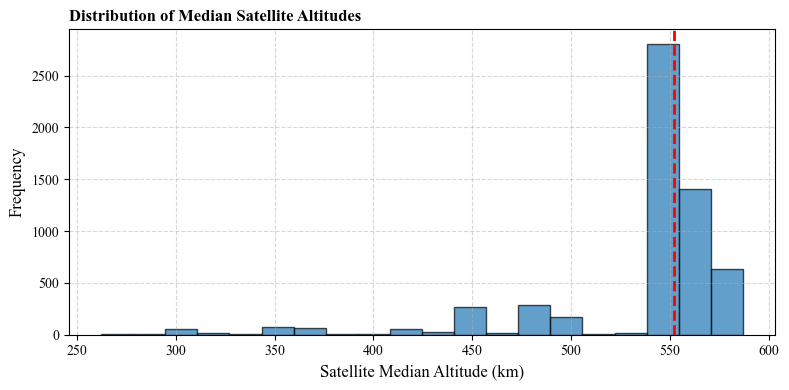

In [13]:
# Satellite mean heights
# Define mean satellite heights (assuming starlink_alts is available and structured)
median_heights = np.asarray([sat["median_altitude"] for sat in starlink_alts.values()])

# Create the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Define the number of bins and color scheme
num_bins = 20
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Plot the histogram with customized styling
ax.hist(median_heights, bins=num_bins, color=colors[0], edgecolor='black', alpha=0.7)

# Configure plot aesthetics
ax.set_xlabel('Satellite Median Altitude (km)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title("Distribution of Median Satellite Altitudes", fontweight="bold", loc="left")
ax.grid(True, linestyle='--', alpha=0.5)

# Add a vertical line indicating the mean altitude
median_value = np.nanmedian(median_heights)
ax.axvline(median_value, color='red', linestyle='--', linewidth=2, label=f'Median Altitude: {median_value:.2f} km')

# # Create legend
# ax.legend(loc='bottom center', fontsize=10)

# Adjust layout for better spacing and save the plot
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
def clean_array(arr):
    """Clean array of NaN and Inf values"""
    arr = np.array(arr, dtype=np.float32)  # Initial conversion to float32
    arr[~np.isfinite(arr)] = np.nan  # Convert inf to nan
    valid_mean = np.nanmean(arr)
    
    if np.isnan(valid_mean):
        return np.zeros_like(arr, dtype=np.float16)
        
    arr = np.nan_to_num(arr, nan=valid_mean)
    return np.array(arr, dtype=np.float16)

def check_time_consistency(times):
    """Check if time steps are consistent"""
    time_stamps = np.array([t.timestamp() for t in times])
    time_diffs = np.diff(time_stamps)
    is_consistent = np.allclose(time_diffs, time_diffs[0], rtol=0, atol=1)
    return (True, time_diffs[0]) if is_consistent else (False, None)

def optimize_with_full_times(sat_data):
    """Fallback optimization keeping all time arrays"""
    print("Using full time arrays for each satellite")
    satellites = {}
    skipped = 0
    
    for i, (sat_id, data) in enumerate(tqdm(sat_data.items())):
        try:
            # Clean and convert arrays
            lats = clean_array(data['latitudes'])
            lons = clean_array(data['longitudes'])
            alts = clean_array(data['altitudes'])
            
            # Skip if all values were invalid
            if np.all(lats == 0) or np.all(lons == 0) or np.all(alts == 0):
                skipped += 1
                continue
            
            satellites[sat_id] = {
                'name': data['name'],
                'times': data['times'],
                'lat': lats.tolist(),
                'lon': lons.tolist(),
                'alt': alts.tolist()
            }
        except Exception as e:
            print(f"Error processing satellite {sat_id}: {e}")
            skipped += 1
            continue
    
    print(f"Skipped {skipped} satellites with invalid values")
    return {'satellites': satellites}

def optimize_sat_data(sat_data):
    """Optimize with shared time points verification"""
    first_sat = next(iter(sat_data.values()))
    times = first_sat['times']
    
    is_consistent, time_step = check_time_consistency(times)
    if not is_consistent:
        print("Warning: Time steps are not consistent! Using full time arrays.")
        return optimize_with_full_times(sat_data)
    
    metadata = {
        'start_time': times[0],
        'time_step': float(time_step),
        'n_steps': len(times)
    }
    
    satellites = {}
    skipped = 0
    
    for sat_id, data in tqdm(sat_data.items()):
        try:
            # Clean and convert arrays
            lats = clean_array(data['latitudes'])
            lons = clean_array(data['longitudes'])
            alts = clean_array(data['altitudes'])
            
            # Skip if all values were invalid
            if np.all(lats == 0) or np.all(lons == 0) or np.all(alts == 0):
                skipped += 1
                continue
            
            satellites[sat_id] = {
                'name': data['name'],
                'lat': lats.tolist(),
                'lon': lons.tolist(),
                'alt': alts.tolist()
            }
        except Exception as e:
            print(f"Error processing satellite {sat_id}: {e}")
            skipped += 1
            continue
    
    print(f"Skipped {skipped} satellites with invalid values")
    return {
        'metadata': metadata,
        'satellites': satellites
    }
    
# Helper function to convert numpy arrays
def convert_numpy(obj):
   if isinstance(obj, np.ndarray):
       return obj.tolist()
   elif isinstance(obj, dict):
       return {k: convert_numpy(v) for k,v in obj.items()}
   elif isinstance(obj, list):
       return [convert_numpy(i) for i in obj]
   return obj

# Process and save
optimized_sats = optimize_sat_data(starlink_sats_current)
with open("./sat_model_web/data/all_sats_optimized.json", "w") as f:
    json.dump(convert_numpy(optimized_sats), f, default=str)  # Removed indent=2 to save space

100%|█████████████████████████████████████████████████████████████████████████| 7026/7026 [00:01<00:00, 5463.01it/s]


Skipped 0 satellites with invalid values


In [16]:
def trim_satellite_data(sat_data, max_sats=1500):
    sat_ids = np.array(list(sat_data.keys()))
    
    if len(sat_ids) > max_sats:
        # Randomly select satellite IDs to keep
        sampled_ids = np.random.choice(sat_ids, max_sats, replace=False)
        trimmed_data = {sat_id: sat_data[sat_id] for sat_id in sampled_ids}
        print(f"Trimmed down to {max_sats} satellites for visualization.")
        return trimmed_data
    else:
        print("No trimming required; dataset is already below the threshold.")
        return sat_data

# Example usage with your optimize function
trimmed_data = trim_satellite_data(starlink_sats_current, max_sats=1500)
optimized_sats = optimize_sat_data(trimmed_data)

# Save the optimized data
with open("./sat_model_web/data/all_sats_optimized.json", "w") as f:
    json.dump(convert_numpy(optimized_sats), f, default=str)

Trimmed down to 1500 satellites for visualization.


100%|█████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 5658.29it/s]


Skipped 0 satellites with invalid values


In [17]:
def compare_drag_parameters(tle_line1, area=5.2, cd=2.2, mass=1.0):
    # Extract and parse B* from TLE
    bstar_raw = tle_line1[53:61]
    bstar = float(bstar_raw[:6]) * 10**int(bstar_raw[7])  # Parse scientific notation
    
    # Convert to SI units (m⁻¹)
    earth_radius = 6371000  # meters
    bstar_converted = bstar / earth_radius
    
    # Assumed ballistic coefficient
    assumed_beta = mass / (cd * area)
    
    return bstar_converted, assumed_beta

def get_sat_velocity_drag(tle_line1, tle_line2, area=5.2, cd=2.2, mass=275):
    # Load satellite and current time
    sat = EarthSatellite(tle_line1, tle_line2)
    ts = load.timescale()
    t = ts.now()
    
    # Get satellite velocity and position
    geocentric = sat.at(t)
    velocity = geocentric.velocity.km_per_s
    speed_skyfield = np.sqrt(np.sum(np.array(velocity)**2))
    
    # Get altitude and orbital radius
    alt = geocentric.subpoint().elevation.km
    r = alt + 6371  # Earth radius in km
    
    # Simple orbital velocity
    GM = 398600.4418  # Earth's GM in km³/s²
    speed_simple = np.sqrt(GM / r)
    
    # Estimate atmospheric density at altitude
    rho = 1.225 * np.exp(-alt / 7.249)
    
    # Compute drag force
    drag_skyfield = 0.5 * cd * rho * area * (speed_skyfield**2)
    drag_simple = 0.5 * cd * rho * area * (speed_simple**2)
    
    return speed_skyfield, speed_simple, drag_skyfield, drag_simple

def calculate_drag_from_tle(tle_line1, tle_line2, mass=1.0):
    # Parse B* from TLE (scientific notation parsing)
    bstar_raw = tle_line1[53:61]
    bstar = float(bstar_raw[:6]) * 10**int(bstar_raw[7])  # Convert B* to normalized units
    
    # Load satellite and get velocity
    sat = EarthSatellite(tle_line1, tle_line2)
    ts = load.timescale()
    t = ts.now()
    
    geocentric = sat.at(t)
    velocity = geocentric.velocity.km_per_s
    speed = np.sqrt(np.sum(np.array(velocity)**2))  # Magnitude of velocity (km/s)
    
    # Convert speed to m/s
    speed = speed * 1000  # Convert to m/s
    
    # Drag force calculation (B* in normalized units)
    drag_force = 0.5 * bstar * mass * speed**2  # N
    
    return drag_force, speed

sat = starlink_current['58043']['tles']
tle_line1 = sat[0]['line1']
tle_line2 = sat[0]['line2']

# speed_sf, speed_sim, drag_sf, drag_sim = get_sat_velocity_drag(tle_line1, tle_line2)
# print(f"Skyfield: {speed_sf:.2f} km/s, {drag_sf:.2e} N")
# print(f"Simple:   {speed_sim:.2f} km/s, {drag_sim:.2e} N")

In [18]:
area = 5.2  # m²
cd = 2.2
mass = 275  # kg
compare_drag_parameters(tle_line1, mass=mass)

# Compute drag parameters
speed_sf, speed_sim, drag_sf, drag_sim = get_sat_velocity_drag(tle_line1, tle_line2, area=5.2, cd=2.2, mass=275)
print(f"Skyfield: {speed_sf:.2f} km/s, Drag: {drag_sf:.2e} N")
print(f"Simple:   {speed_sim:.2f} km/s, Drag: {drag_sim:.2e} N")

# Compare B* and ballistic coefficient
b_star_converted, assumed_beta = compare_drag_parameters(tle_line1, area=5.2, cd=2.2, mass=275)
print(f"Converted B*: {b_star_converted:.2e} m⁻¹")
print(f"Ballistic coefficient (β): {assumed_beta:.2f} kg/m²")

Skyfield: 7.64 km/s, Drag: 7.11e-26 N
Simple:   7.64 km/s, Drag: 7.11e-26 N
Converted B*: 4.93e+00 m⁻¹
Ballistic coefficient (β): 24.04 kg/m²


In [19]:
# Calculate bin edges
min_altitude = np.nanmin(median_heights)
max_altitude = np.nanmax(median_heights)
bins = np.linspace(min_altitude, max_altitude, 9)  # 8 bins, 9 edges

# Create bin labels
bin_labels = [f"Bin {i+1} ({int(bins[i])} km - {int(bins[i+1])} km)" for i in range(8)]

# Classify satellites
satellite_classifications = []
for sat_id, sat_data in starlink_alts.items():
    try:
        median_altitude = sat_data['median_altitude']
        
        # Find bin index (with small offset to handle edge cases)
        bin_index = np.digitize(median_altitude - 0.01, bins) - 1
        
        # Get classification label
        bin_label = bin_labels[bin_index]
        
        satellite_classifications.append({
            "Satellite ID": sat_id,
            "Satellite Name": sat_data["name"],
            "Median Altitude (km)": median_altitude,
            "Altitude Bin": bin_label
        })
    except IndexError:
        print(f"Error classifying satellite {sat_id} with median altitude {median_altitude}")
        continue

# Create DataFrame
classification_df = pd.DataFrame(satellite_classifications)
classification_df.head(5)

Satellite ID  Satellite Name  Median Altitude (km)             Altitude Bin
0        59489  STARLINK-59489            423.215594  Bin 4 (383 km - 424 km)
1        59499  STARLINK-59499            445.063064  Bin 5 (424 km - 465 km)
2        59506  STARLINK-59506            423.397763  Bin 4 (383 km - 424 km)
3        59503  STARLINK-59503            423.007310  Bin 4 (383 km - 424 km)
4        59493  STARLINK-59493            423.096461  Bin 4 (383 km - 424 km)

In [20]:
def apply_lowess(times, altitudes, frac=0.1):
    """
    Apply LOWESS smoothing to fit a central trend line.
    
    Parameters:
    - times: List of datetime objects
    - altitudes: List of altitude values
    - frac: The fraction of data points to include in the smoothing window.
    
    Returns:
    - smoothed_times: The same times as input
    - smoothed_altitudes: Smoothed altitude values
    """
    # Convert times to numerical format (e.g., seconds since start)
    time_nums = [(t - times[0]).total_seconds() for t in times]
    # 
    # Perform LOWESS smoothing
    smoothed = lowess(altitudes, time_nums, frac=frac, return_sorted=False)
    
    return times, smoothed

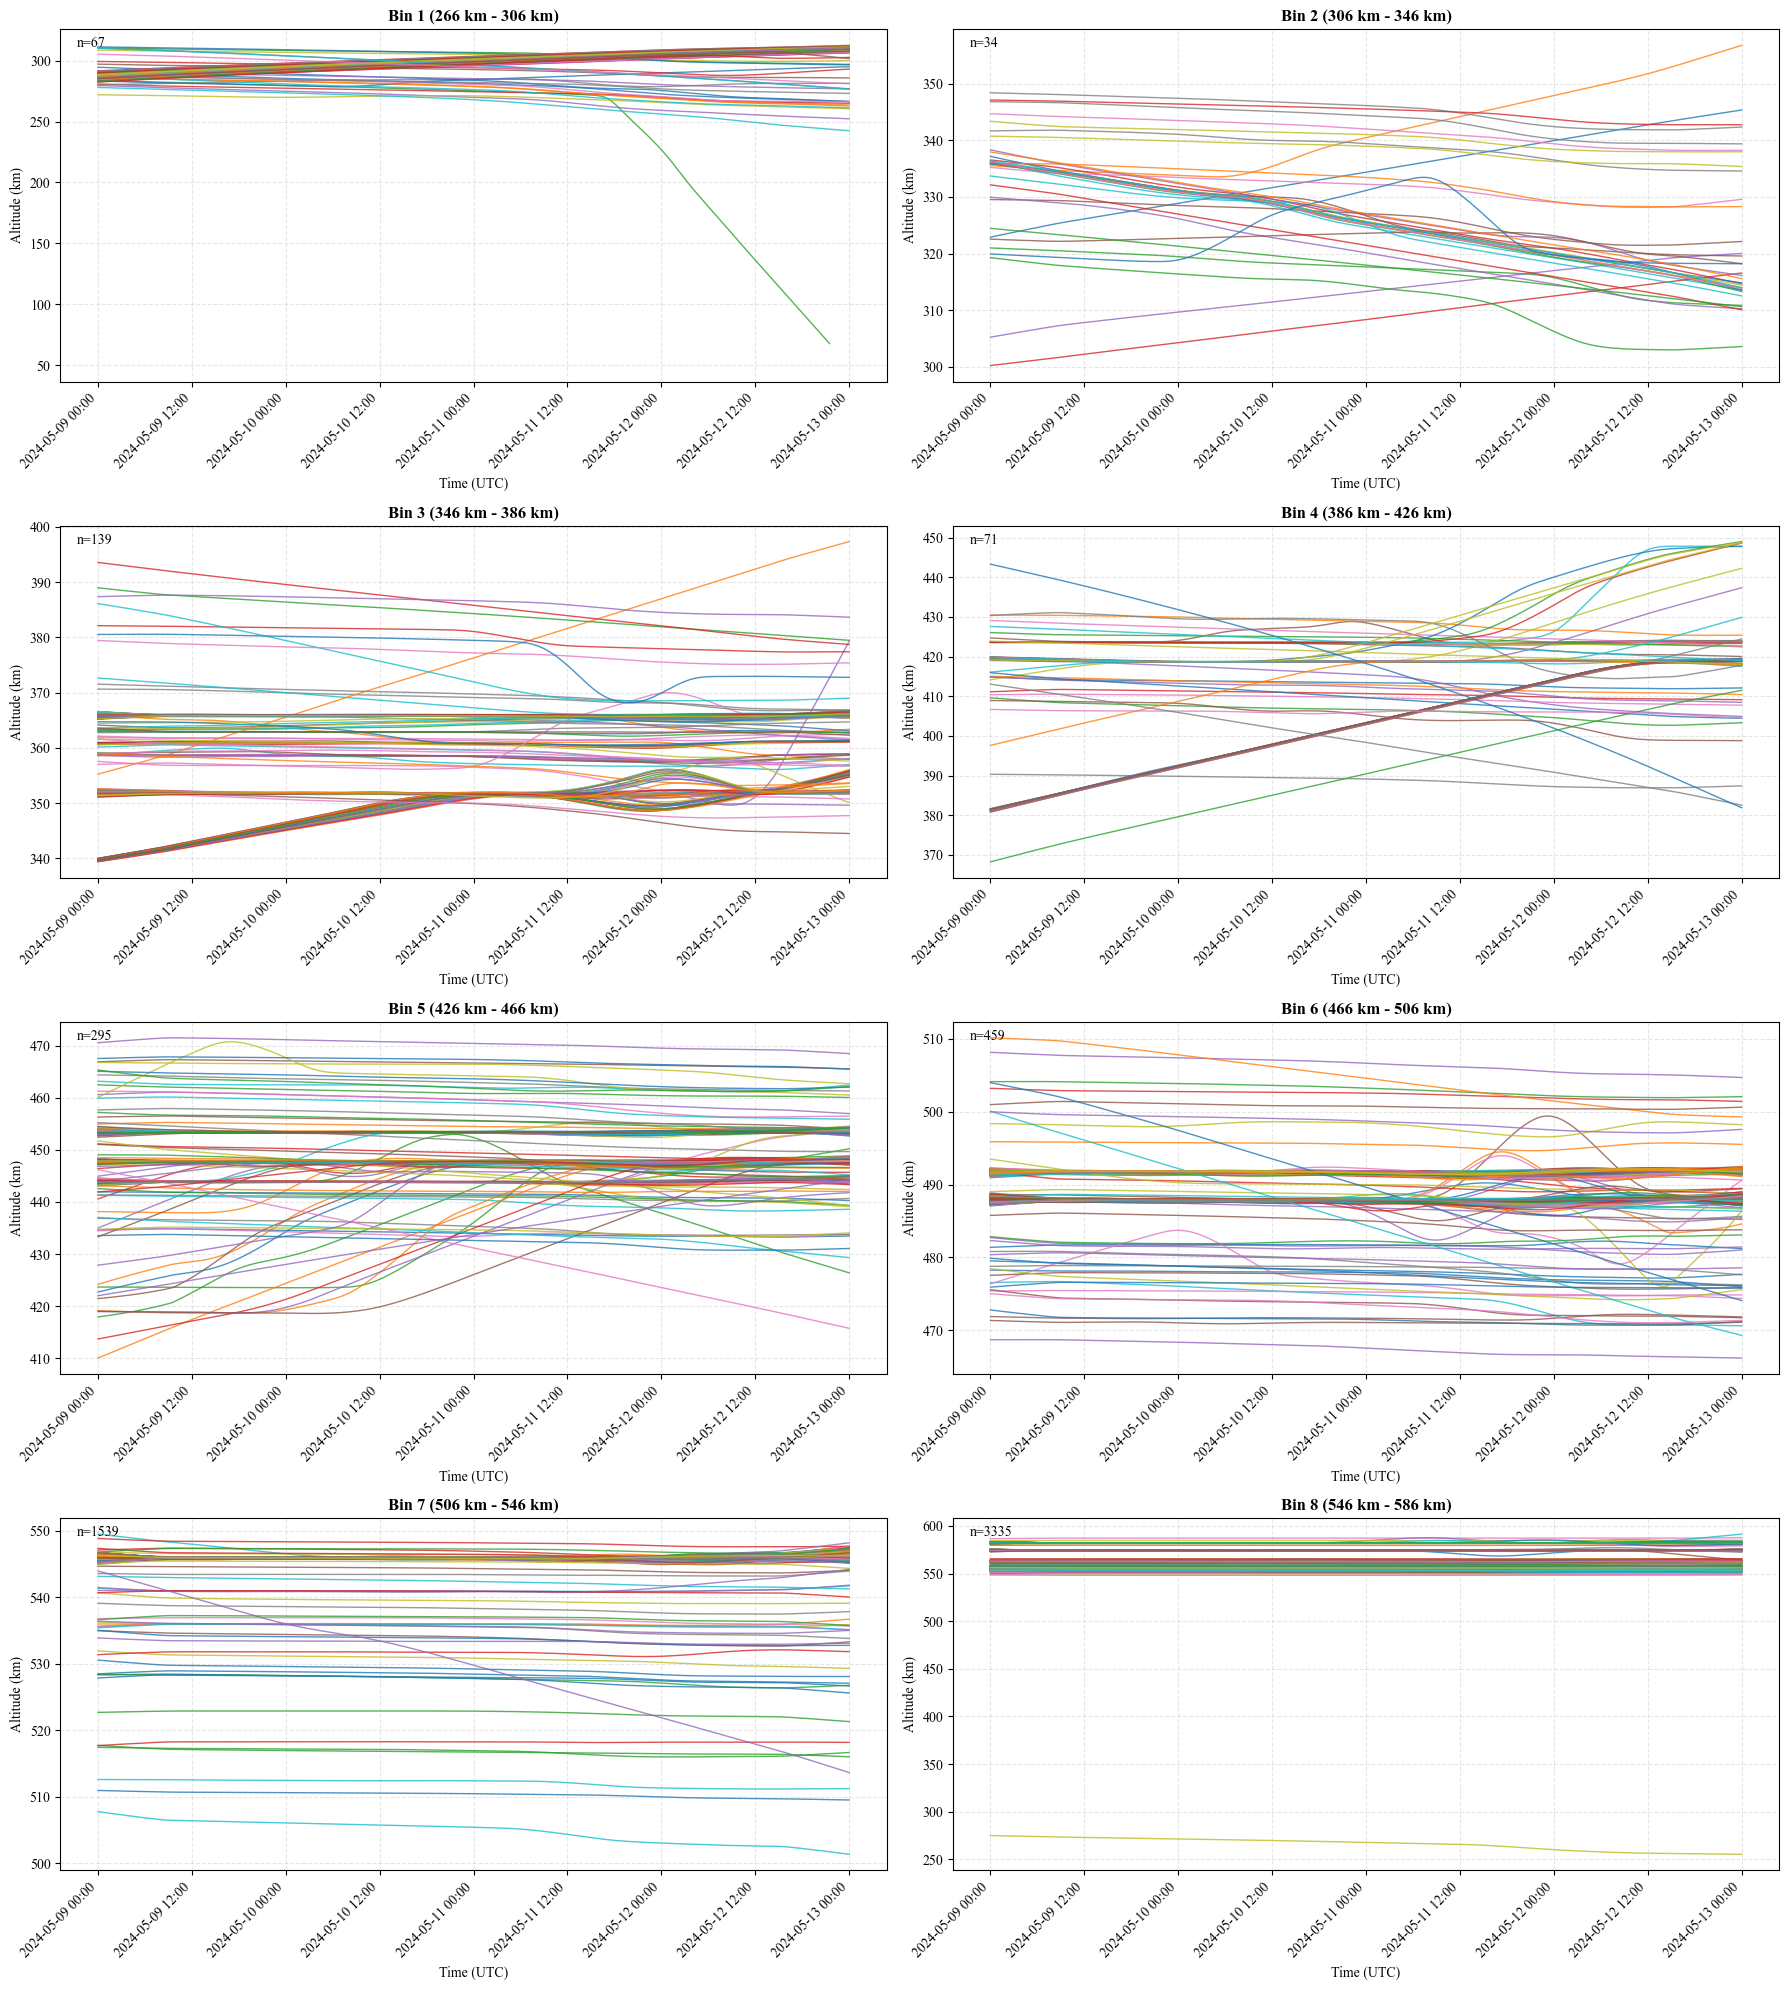

In [19]:
# Create a grid layout (2 columns by 4 rows)
fig = plt.figure(figsize=(18, 20))
gs = gridspec.GridSpec(4, 2, figure=fig)

# Extract unique bins from the classification DataFrame
altitude_bins = sorted(classification_df['Altitude Bin'].unique())

# Iterate through each altitude bin and plot smoothed data for satellites in that bin
for i, bin_label in enumerate(altitude_bins):
    ax = fig.add_subplot(gs[i])
    
    # Extract satellite data for the current bin
    satellites_in_bin = classification_df[classification_df["Altitude Bin"] == bin_label]
    
    # Sample 10 satellites randomly if more than 10 exist
    if len(satellites_in_bin) > 3000:
        sampled_satellites = satellites_in_bin.sample(n=2000, random_state=42)
    else:
        sampled_satellites = satellites_in_bin
    
    # Iterate through each sampled satellite in the bin
    for _, sat_data in sampled_satellites.iterrows():
        sat_id = sat_data['Satellite ID']
        satellite_data = starlink_alts[sat_id]
        times = satellite_data['times']
        altitudes = satellite_data['altitudes']
        
        # Skip if insufficient data
        if len(times) < 5:
            continue
        
        # Apply LOWESS smoothing
        smoothed_times, smoothed_altitudes = apply_lowess(times, altitudes, frac=0.2)
        
        # Plot the smoothed altitude data for this satellite (without label)
        ax.plot(smoothed_times, smoothed_altitudes, linewidth=1, alpha=0.8)
    
    # Set titles and labels for the plot
    ax.set_title(f"{bin_label}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Time (UTC)", fontsize=10)
    ax.set_ylabel("Altitude (km)", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Format x-axis to show dates nicely
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add text showing number of satellites in bin
    total_in_bin = len(satellites_in_bin)
    ax.text(0.02, 0.98, f"n={total_in_bin}", 
            transform=ax.transAxes, 
            fontsize=10,
            verticalalignment='top')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

## Drag Estimates with Empirical Models

## Kp and Flux Data Loading

In [21]:
# Read Kp and solar flux data
# Read fluxtable data
colnames_flux = [
    "fluxdate",
    "fluxtime",
    "fluxjulian",
    "fluxcarrington",
    "fluxobsflux",
    "fluxadjflux",
    "fluxursi",
]
fluxtable = pd.read_csv(
    "data/fluxtable.txt", delim_whitespace=True, names=colnames_flux
)

# Convert fluxdate and fluxtime into a single datetime object
fluxtable["datetime"] = pd.to_datetime(
    fluxtable["fluxdate"].astype(str) + fluxtable["fluxtime"].astype(str),
    format="%Y%m%d%H%M%S",
)


# Read kp_data
colnames_kp = [
    "year",
    "month",
    "day",
    "time",
    "kp_index",
    "julian_start",
    "julian_end",
    "kp_sum",
    "ap",
    "flag",
]
kp_data = pd.read_csv("data/Kp index.txt", delim_whitespace=True, names=colnames_kp)

# Convert year, month, day, and time into a single datetime object
kp_data["datetime"] = pd.to_datetime(
    kp_data[["year", "month", "day"]].astype(str).agg("-".join, axis=1)
    + " "
    + kp_data["time"].astype(str),
    format="%Y-%m-%d %H.%M",
)

# Gannon storm
# Define the Gannon storm period
storm_start = datetime(2024, 5, 9)
storm_end = datetime(2024, 5, 13)

# Create time array for the storm period
storm_dates = pd.date_range(start=storm_start, end=storm_end, freq="30min")

# Match your existing Kp and flux data for the storm period
kp_storm = kp_data[
    (kp_data["datetime"] >= storm_start) & (kp_data["datetime"] <= storm_end)
]

flux_storm = fluxtable[
    (fluxtable["datetime"] >= storm_start) & (fluxtable["datetime"] <= storm_end)
]

In [22]:
# Get unique altitude bins and their median altitudes
altitude_bins = sorted(classification_df['Altitude Bin'].unique())
bin_medians = {}

for bin_label in altitude_bins:
    satellites_in_bin = classification_df[classification_df['Altitude Bin'] == bin_label]
    median_alt = satellites_in_bin['Median Altitude (km)'].median()
    bin_medians[bin_label] = median_alt
    print(bin_label)

Bin 1 (262 km - 302 km)
Bin 2 (302 km - 343 km)
Bin 3 (343 km - 383 km)
Bin 4 (383 km - 424 km)
Bin 5 (424 km - 465 km)
Bin 6 (465 km - 505 km)
Bin 7 (505 km - 546 km)
Bin 8 (546 km - 586 km)


In [23]:
def calculate_global_densities(window_start, window_end, classification_df, time_step_minutes=10):
    """
    Calculate global atmospheric densities for classified altitude bins.
    
    Parameters:
    -----------
    window_start, window_end : datetime
        Start and end times for the analysis window
    classification_df : pandas DataFrame
        DataFrame containing satellite classifications with altitude bins
    time_step_minutes : int
        Time step in minutes for density calculations
    
    Returns:
    --------
    dict: Results containing density arrays and altitude information
    """
    # Setup spatial grid
    lons = np.arange(-180, 185, 5)
    lats = np.arange(-90, 95, 5)
    
    # Get unique altitude bins and their median altitudes
    altitude_bins = sorted(classification_df['Altitude Bin'].unique())
    bin_medians = {}
    
    for bin_label in altitude_bins:
        satellites_in_bin = classification_df[classification_df['Altitude Bin'] == bin_label]
        median_alt = satellites_in_bin['Median Altitude (km)'].median()
        bin_medians[bin_label] = median_alt
    
    # Generate time steps
    time_steps = []
    current_time = window_start
    while current_time <= window_end:
        time_steps.append(current_time)
        current_time += timedelta(minutes=time_step_minutes)
    
    # Initialize results structure
    results = {
        'times': time_steps,
        'coordinates': {
            'lons': lons,
            'lats': lats
        },
        'bin_data': {}
    }
    
    # Process each bin
    for bin_label in tqdm(altitude_bins, desc="Processing altitude bins"):
        bin_med = bin_medians[bin_label]
        
        # Generate altitude levels for this bin
        altitudes = []
        level_names = []
        
        for offset in [-10, -5, 0, 5, 10]:
            alt = bin_med + offset
            if alt >= 100:  # Check minimum threshold
                altitudes.append(alt)
                level_names.append(f'h{offset:+d}' if offset != 0 else 'h_med')
        
        outputs = []  # Store outputs for all time steps
        
        # Process each time step
        for current_time in time_steps:
            # Get F10.7 and ap values
            f107, f107a, aps = pymsis.utils.get_f107_ap(current_time)
            
            # Run MSIS for all altitudes at once
            output = msis.run(
                np.array([current_time]),
                lons,
                lats,
                altitudes,
                [f107],
                [f107a],
                [aps]
            )
            
            outputs.append({
                'time': current_time,
                'densities': np.squeeze(output),  # Shape: (73, 73, n_alts, 11)
                'altitudes': altitudes,
                'level_names': level_names,
                'parameters': {
                    'f107': f107,
                    'f107a': f107a,
                    'ap': aps
                }
            })
        
        # Store in results
        results['bin_data'][bin_label] = {
            'median_height': bin_med,
            'altitude_levels': altitudes,
            'level_names': level_names,
            'outputs': outputs,
            'satellites': classification_df[classification_df['Altitude Bin'] == bin_label]['Satellite ID'].tolist()
        }
    
    return results

# densities_dict = calculate_global_densities(
#     storm_start,
#     storm_end,
#     classification_df,
#     time_step_minutes=10
# )

In [24]:
def calculate_density_grid(lats, lons, current_time, altitudes, output_file='sat_model_web/data/density_grid.json'):
    """
    Calculate density using MSIS of a  US grid
    Args:
        lats: numpy array of latitudes
        lons: numpy array of longitudes
        current_time: datetime object in UTC
        altitudes: array of altitudes in km
        output_file: path to save output
    """
    lons_copy = lons.copy()
    lats_copy = lats.copy()
    try:
        # Get F10.7 and ap values
        f107, f107a, aps = pymsis.utils.get_f107_ap(current_time)
        print(f107, f107a, aps)
        
        # Run MSIS for all points at once
        output = msis.run(
            np.array([current_time]),
            lons_copy,
            lats_copy,
            altitudes,
            [f107],
            [f107a],
            [aps]
        )
        
        # Squeeze output ((1, 73, 37, 1, 11)) to get (73, 37, n_alts, 11)
        densities = np.squeeze(output)
        
        # Prepare data structure
        data = {
            "time": current_time.isoformat(),
            "lats": lats.tolist(),
            "lons": lons.tolist(),
            "altitudes": altitudes.tolist(),
            "f107": float(f107),
            "f107a": float(f107a),
            "aps": aps.tolist() if isinstance(aps, np.ndarray) else float(aps),
            "densities": densities.astype(np.float32).tolist()
        }
        
        # Save to JSON
        with open(output_file, 'w') as f:
            json.dump(data, f)
            
        print(f"Saved densities with shape {densities.shape}")
        return densities
        
    except Exception as e:
        print(f"Error in density calculation: {e}")
        raise

current_time = datetime.now(timezone.utc)
lats = np.arange(-90, 95, 5)  # 37 points
lons = np.arange(-180, 185, 5)  # 73 points
altitudes = np.array([400])  # or whatever altitudes you need

# output = calculate_density_grid(lats, lons, current_time, altitudes)

In [25]:
for bin_label in altitude_bins:
    print(bin_label)

Bin 1 (262 km - 302 km)
Bin 2 (302 km - 343 km)
Bin 3 (343 km - 383 km)
Bin 4 (383 km - 424 km)
Bin 5 (424 km - 465 km)
Bin 6 (465 km - 505 km)
Bin 7 (505 km - 546 km)
Bin 8 (546 km - 586 km)


## Explore variation in densities at different altitudes

In [26]:
for bin_label in altitude_bins:
    # Get data array and times
    density_data = np.array([output['densities'] for output in densities_dict['bin_data'][bin_label]['outputs']])
    times = np.array([output['time'] for output in densities_dict['bin_data'][bin_label]['outputs']])
    
    # Setup coordinates
    lons = np.arange(-180, 185, 5)
    lats = np.arange(-90, 95, 5)
    
    # Create figure with fixed size
    fig = plt.figure(figsize=(20, 20))
    
    # Calculate time steps (4 hours = 24 ten-minute intervals)
    time_step = 24
    n_panels = 16  # 4x4 grid
    start_indices = np.arange(0, n_panels) * time_step
    
    # Create gridspec for 4x4 layout - adjust bottom to make room for colorbar
    outer_gs = fig.add_gridspec(4, 4, hspace=0.1, wspace=0.1, bottom=0.1)
    
    # Selected latitudes for plotting
    lat_indices = {
        'Equator': len(lats)//2,      # 0°
        'Low-N': len(lats)//2 + 3,    # 15°N
        'Low-S': len(lats)//2 - 3,    # 15°S
        'Mid-N': len(lats)//2 + 9,    # 45°N
        'Mid-S': len(lats)//2 - 9,    # 45°S
        'High-N': len(lats)//2 + 15   # 75°N
    }
    
    # Use a color cycle that matches the map width
    colors = plt.cm.Set2(np.linspace(0, 1, len(lat_indices)))
    
    # Set up normalization for plotting
    vmin = np.min(density_data[:, :, :, 2, 0])
    vmax = np.max(density_data[:, :, :, 2, 0])
    norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
    
    # Create mesh grid for plotting
    xx, yy = np.meshgrid(lons, lats)
    
    # Store line objects for legend
    legend_lines = []
    legend_labels = []
    
    # Plot each panel
    for panel_idx, time_idx in enumerate(start_indices):
        if time_idx >= len(times):
            break
            
        # Create nested gridspec for this panel
        inner_gs = outer_gs[panel_idx // 4, panel_idx % 4].subgridspec(2, 1, height_ratios=[1, 4], hspace=0.1)
        
        # Create axes
        ax_lon = fig.add_subplot(inner_gs[0])
        ax_map = fig.add_subplot(inner_gs[1], projection=ccrs.PlateCarree())
        
        current_time = times[time_idx]
        
        # Plot density map
        mesh = ax_map.pcolormesh(xx, yy, 
                                density_data[time_idx, :, :, 2, 0].T,
                                shading="auto", 
                                norm=norm,
                                transform=ccrs.PlateCarree())
        ax_map.coastlines()
        ax_map.gridlines()
        
        # Plot longitude variations
        for (lat_name, lat_idx), color in zip(lat_indices.items(), colors):
            lon_data = density_data[time_idx, :, lat_idx, 2, 0]
            line = ax_lon.plot(lons, lon_data, color=color)
            
            # Store only once for legend
            if panel_idx == 0:
                legend_lines.append(line[0])
                legend_labels.append(f'{lat_name} ({lats[lat_idx]:.0f}°)')
        
        # Customize longitude plot
        ax_lon.set_xlim(-180, 180)
        ax_lon.set_ylim(vmin, vmax)
        ax_lon.grid(True, alpha=0.3)
        ax_lon.set_title(f'{current_time.strftime("%Y-%m-%d %H:%M")} UTC')
        
        # Calculate and plot sun position
        sun_loc = 180 - (mdates.date2num([current_time])[0] % 1) * 360
        sun = ax_map.plot(sun_loc, 0, '.', c='gold', markersize=15, 
                         transform=ccrs.PlateCarree())[0]
        
        # Add horizontal lines on map with matching colors
        for (lat_name, lat_idx), color in zip(lat_indices.items(), colors):
            ax_map.axhline(lats[lat_idx], color=color, linestyle='--', alpha=0.5)
        
        # Set labels
        if panel_idx >= 12:  # Bottom row
            ax_map.set_xlabel('Longitude')
        if panel_idx % 4 == 0:  # Left column
            ax_map.set_ylabel('Latitude')
            ax_lon.set_ylabel('Mass Density')
        
        # Set same width for both plots
        ax_lon.set_xlim(ax_map.get_xlim())
    
    # Add single legend at the top of the figure
    fig.legend(legend_lines, legend_labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 0.92),
              ncol=len(lat_indices),
              frameon=False)

    # Create new axis for colorbar at bottom
    cbar_ax = fig.add_axes([0.13, 0.1, 0.75, 0.01])  # [left, bottom, width, height]
    
    # Add the colorbar
    cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Mass Density (kg/m³)', size=12)
    
    fig.savefig(f"figures/density_profile_{bin_label}.png", dpi=300, bbox_inches='tight')
    plt.show()

NameError: name 'densities_dict' is not defined

## Orbital Mechanics


Orbital velocity:
$$ v = \sqrt{\frac{GM}{r}} $$

Atmospheric drag force:
$$ F_{drag} = \frac{1}{2}C_d\rho v^2A $$

For orbital maintenance:
$$ F_{thrust} = F_{drag} $$

Thruster force:
$$ F_{thrust} = \dot{m}v_e $$
where $v_e = I_{sp}g_0$

Therefore:
$$ \dot{m}v_e = \frac{1}{2}C_d\rho v^2A $$

Solving for mass flow rate:
$$ \dot{m} = \frac{F_{drag}}{v_e} = \frac{1}{2}\frac{C_d\rho v^2A}{I_{sp}g_0} $$

Total propellant mass used over time Δt:
$$ m_{prop} = \dot{m}\Delta t = \frac{1}{2}\frac{C_d\rho v^2A}{I_{sp}g_0}\Delta t $$

In [23]:
def calculate_propellant_usage(results):
    """Calculate propellant usage from results dictionary."""
    try:
        total_by_sat = {}
        for sat_id in results:
            dt = np.diff([t.timestamp() for t in results[sat_id]['times']])
            m_dots = np.array(results[sat_id]['mass_flow_rates'][:-1])
            propellant = np.sum(m_dots * dt)
            results[sat_id]['propellant_used'] = propellant
            total_by_sat[sat_id] = propellant
            
    except Exception as e:
        logging.error(f"Error calculating propellant usage: {e}")
    return results

def calculate_drag_propellant(starlink_alts, condition='actual', Isp=4000, A=5, Cd=2.2, G=6.67430e-11, M=5.972e24):
    """
    Calculate drag and propellant usage for constellation
    
    Parameters:
    - condition: 'actual', 'quiet', or 'storm'
    """
    logging.basicConfig(level=logging.INFO)
    
    results = {}
    density_stats = {'min': float('inf'), 'max': float('-inf'), 'sum': 0, 'count': 0}
    
    # Define conditions:
    conditions = {
        'quiet': {
            'f107': 65.0,    # Solar minimum
            'f107a': 65.0,   # Sustained minimum
            'aps': [2.0] * 7  # Very quiet geomagnetic
        },
        'storm': {
            'f107': 230.0,   # Very high solar activity
            'f107a': 200.0,  # Sustained high activity
            'aps': [50.0] * 7  # Strong geomagnetic storm
        }
    }
    
    for sat_id, sat_info in starlink_alts.items():
        try:
            times = sat_info['times']
            lats  = sat_info['latitudes']
            lons  = sat_info['longitudes']
            alts  = sat_info['altitudes']
            
            sgp4_velocities = sat_info['velocities']
            sgp_pos = sat_info['cartesian_positions']
            vx = np.array(sgp4_velocities['vx'])
            vy = np.array(sgp4_velocities['vy'])
            vz = np.array(sgp4_velocities['vz'])
            x = sgp_pos["x"]
            y = sgp_pos["y"] 
            z = sgp_pos["z"]
            
            v_vec = np.column_stack((vx, vy, vz))
            p_vec = np.column_stack((x, y, z))


            if condition == 'actual':
                # Vectorize f107, f107a, and aps extraction
                f107, f107a, aps = zip(*[pymsis.utils.get_f107_ap(t) for t in times])
                f107, f107a, aps = list(f107), list(f107a), list(aps)
            else:
                f107  = [conditions[condition]['f107']] * len(times)
                f107a = [conditions[condition]['f107a']] * len(times)
                aps   = [conditions[condition]['aps']] * len(times)

            # Run MSIS in a vectorized fashion
            msis_op = msis.run(
                np.array(times),
                lons,
                lats,
                alts,
                f107s=f107,
                f107as=f107a,
                aps=aps,
                geomagnetic_activity=-1
            )
            
            densities = msis_op[:, 0]

            r_norm = np.linalg.norm(r_vec, axis=1)
            r_hat = r_vec / r_norm[:, None]

            # Compute the radial component of the velocity vector
            v_radial = np.sum(v_vec * r_hat, axis=1)[:, None] * r_hat
            # Tangential velocity is what's left after removing the radial component
            v_tangential = v_vec - v_radial
            v_t_mag = np.linalg.norm(v_tangential, axis=1)

            # Compute drag force (F_drag = 0.5 * Cd * density * (v_t)^2 * A)
            drag_forces = 0.5 * Cd * densities * (v_t_mag**2) * A
            mass_flow_rates = drag_forces / (Isp * 9.81)

            results[sat_id] = {
                'times': times.tolist(),
                'densities': densities.tolist(),
                'tangential_velocities': v_t_mag.tolist(),
                'drag_forces': drag_forces.tolist(),
                'mass_flow_rates': mass_flow_rates.tolist(),
                'f107': f107.tolist(),
                'f107a': f107a.tolist(),
                'ap': aps.tolist()
            }

            density_stats['min'] = min(density_stats['min'], np.min(densities))
            density_stats['max'] = max(density_stats['max'], np.max(densities))
            density_stats['sum'] += np.sum(densities)
            density_stats['count'] += len(densities)

        except Exception as e:
            logging.warning(f"Error processing satellite {sat_id}: {e}")
            continue

    print(f"\n{condition.title()} Density Statistics:")
    print(f"Min density: {density_stats['min']:.2e} kg/m³")
    print(f"Max density: {density_stats['max']:.2e} kg/m³")
    print(f"Mean density: {density_stats['sum']/density_stats['count']:.2e} kg/m³")
    return results

def load_or_calculate_results():
   # Try to load existing results
   if os.path.exists('starlink_drag_comparison_full.pkl'):
       print("Loading existing results...")
       with open('starlink_drag_comparison_full.pkl', 'rb') as f:
           results = pickle.load(f)
           actual_results = results['actual']
           quiet_results = results['quiet'] 
           storm_results = results['storm']
   else:
       print("Calculating new results...")
       # Calculate all three conditions...
       actual_results = calculate_drag_propellant(starlink_alts, condition='actual')
       actual_results = calculate_propellant_usage(actual_results)
       
       quiet_results = calculate_drag_propellant(starlink_alts, condition='quiet')
       quiet_results = calculate_propellant_usage(quiet_results)
       
       storm_results = calculate_drag_propellant(starlink_alts, condition='storm')
       storm_results = calculate_propellant_usage(storm_results)
       
       # Save results
       with open('starlink_drag_comparison_full.pkl', 'wb') as f:
           pickle.dump({
               'actual': actual_results,
               'quiet': quiet_results,
               'storm': storm_results
           }, f)
   
   # Create tabulated comparison
   comparison_data = []
   for alt in sorted(actual_results.keys()):
       row = {
           'Altitude (km)': alt,
           'Quiet Propellant (kg)': quiet_results[alt]['propellant_used'],
           'Actual Propellant (kg)': actual_results[alt]['propellant_used'],
           'Storm Propellant (kg)': storm_results[alt]['propellant_used'],
           'Actual/Quiet Ratio': actual_results[alt]['propellant_used']/quiet_results[alt]['propellant_used'],
           'Storm/Quiet Ratio': storm_results[alt]['propellant_used']/quiet_results[alt]['propellant_used']
       }
       comparison_data.append(row)
   
   # Convert to DataFrame for nice tabular output
   comparison_df = pd.DataFrame(comparison_data)
   comparison_df = comparison_df.round(2)
   
   return actual_results, quiet_results, storm_results, comparison_df

In [24]:
# # Use function
# actual_results, quiet_results, storm_results, comparison_df = load_or_calculate_results()

# # Display tabulated results
# print("\nDetailed Comparison by Altitude:")

In [25]:
satellite_id = "59504"
satellite_59504_alts = starlink_alts[satellite_id]

results_59504 = calculate_drag_propellant({satellite_id:satellite_59504_alts})
densities = results_59504[satellite_id]["densities"]

TypeError: tuple indices must be integers or slices, not str

In [34]:
results_59504[0]

array([[ 3712.57140517, -3523.44511625,  4465.62351848],
       [ 6221.36844185,  -203.76396852,  2725.11640663],
       [ 5991.06941872,  3205.47974234,  -218.37698609],
       ...,
       [ 5264.48239657,  3026.01661396, -3061.24178628],
       [ 1421.88245115,  4834.17646858, -4567.02900501],
       [-3214.06437427,  4461.87191359, -3999.34773125]])

In [33]:
np.sqrt(np.sum(results_59504[0]**2, axis=1))

array([6792.61697246, 6795.08678928, 6798.21312306, 6800.02647359,
       6800.46401766, 6800.23935543, 6799.11026088, 6796.51745749,
       6793.48562103, 6792.36164868, 6794.19342343, 6797.39757791,
       6799.67846309, 6800.42383907, 6800.35309087, 6799.55988686,
       6797.37233901, 6794.24619465, 6792.36483745, 6793.41459893,
       6796.49205996, 6799.19597649, 6800.32556834, 6800.41791367,
       6799.88923281, 6798.13681289, 6795.10995043, 6792.624277  ,
       6792.80972634, 6795.54459626, 6798.5718428 , 6800.14667295,
       6800.44420319, 6800.11740958, 6798.7831613 , 6796.0135933 ,
       6793.11625578, 6792.42624939, 6794.61441207, 6797.81377693,
       6799.86220686, 6800.43173887, 6800.26729085, 6799.30008239,
       6796.89753445, 6793.79856954, 6792.2941105 , 6793.76609655,
       6796.94629612, 6799.45029761, 6800.36954856, 6800.36003092,
       6799.69120518, 6797.71194817, 6794.61563841, 6792.42225608,
       6793.06267575, 6796.01027067, 6798.89764465, 6800.23793

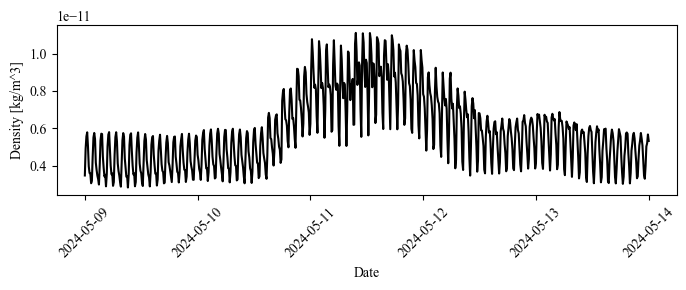

In [14]:
times = satellite_59504_alts['times']
lats  = satellite_59504_alts['latitudes']
lons  = satellite_59504_alts['longitudes']
alts  = satellite_59504_alts['altitudes']

# Vectorize f107, f107a, and aps extraction
f107, f107a, aps = zip(*[pymsis.utils.get_f107_ap(t) for t in times])
f107, f107a, aps = list(f107), list(f107a), list(aps)

msis_op = pymsis.msis.run(
    times,
    lons,
    lats,
    alts,
    f107s=f107,
    f107as=f107a,
    aps=aps,
    geomagnetic_activity=-1
)

plt.figure(figsize=(7, 3))
plt.plot(times, densities, "k")
plt.xlabel("Date")
plt.ylabel("Density [kg/m^3]")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
sat = starlink_gannon[satellite_id]['tles']
tle_line1 = sat[0]['line1']
tle_line2 = sat[0]['line2']

tle_line1, tle_line2

('1 59504U 24071W   24130.00002315  .00022660  00000-0  41502-3 0  9999',
 '2 59504  42.9992 206.6921 0001544 277.0871 187.9615 15.48882023  5230')

In [15]:
satellite_id = "59504"
sat_times = actual_results[satellite_id]['times']

sat = starlink_gannon[satellite_id]['tles']
tle_line1 = sat[0]['line1']
tle_line2 = sat[0]['line2']
start_date = sat_times[0]
end_date = sat_times[-1]

dt_range = pd.date_range(start=start_date, end=end_date, freq="10T", tz="UTC")
tle_line1, tle_line2

NameError: name 'actual_results' is not defined

In [44]:
sat = EarthSatellite(tle_line1, tle_line2)
ts = load.timescale()
ts_times = [ts.utc(
        t.year, t.month, t.day,
        t.hour, t.minute, t.second
    ) for t in dt_range]

# Get satellite velocity and position
geocentrics = [sat.at(t) for t in ts_times]

velocity = np.array([geocentric.velocity.km_per_s for geocentric in geocentrics])
lats = np.array([geocentric.subpoint().latitude.degrees for geocentric in geocentrics])
lons = np.array([geocentric.subpoint().longitude.degrees for geocentric in geocentrics])
alts = np.array([geocentric.subpoint().elevation.km for geocentric in geocentrics])

speed_skyfield = np.sqrt(np.sum(np.array(velocity)**2, axis=1))

In [46]:
lons[0]

-24.69797470764023

In [47]:
# Vectorize f107, f107a, and aps extraction
f107, f107a, aps = zip(*[pymsis.utils.get_f107_ap(t) for t in sat_times])
f107, f107a, aps = list(f107), list(f107a), list(aps)

# Run MSIS in a vectorized fashion
msis_op = msis.run(
    np.array(sat_times),
    lons,
    lats,
    alts,
    f107s=f107,
    f107as=f107a,
    aps=aps,
)

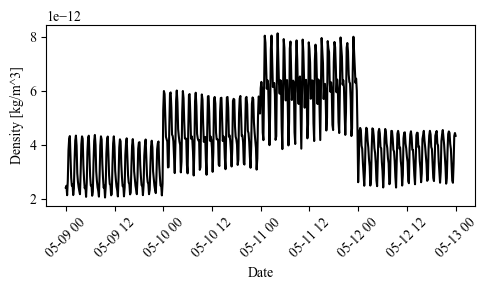

In [26]:
# First calculate average densities for each satellite in each condition
for condition, results in [('actual', actual_results), ('quiet', quiet_results), ('storm', storm_results)]:
    # Calculate averages per satellite
    avg_densities = {sat_id: np.mean(data['densities']) for sat_id, data in results.items()}
    
    # Add to comparison_df
    comparison_df[f'{condition}_avg_density'] = comparison_df['Altitude (km)'].map(avg_densities)

In [27]:
comparison_df.rename(columns={"Altitude (km)": "sat_id"}, inplace=True)
classified_df = classification_df.merge(comparison_df, left_on='Satellite ID', right_on='sat_id', how='inner')

# Now we can include these in the groupby operation
grouped_df = classified_df.groupby('Altitude Bin').agg({
    'Quiet Propellant (kg)': 'sum',
    'Actual Propellant (kg)': 'sum',
    'Storm Propellant (kg)': 'sum',
    'Actual/Quiet Ratio': 'sum',
    'Storm/Quiet Ratio': 'sum',
    'actual_avg_density': 'mean',
    'quiet_avg_density': 'mean',
    'storm_avg_density': 'mean',
    'Satellite ID': 'count'
}).rename(columns={'Satellite ID': 'Satellite Count'})

grouped_df.to_csv("grouped_df.csv", index=False)

grouped_df.reset_index().to_csv("figures/tables_propellant.csv")
grouped_df.head(4)

Quiet Propellant (kg)  Actual Propellant (kg)  \
Altitude Bin                                                             
Bin 1 (266 km - 306 km)               19584.42                19592.16   
Bin 2 (306 km - 346 km)                   0.34                    2.56   
Bin 3 (346 km - 386 km)                   0.23                    6.00   
Bin 4 (386 km - 426 km)                   0.00                    1.44   

                         Storm Propellant (kg)  Actual/Quiet Ratio  \
Altitude Bin                                                         
Bin 1 (266 km - 306 km)               19592.65              411.31   
Bin 2 (306 km - 346 km)                   2.71              294.52   
Bin 3 (346 km - 386 km)                   6.42             1595.26   
Bin 4 (386 km - 426 km)                   1.45             1311.37   

                         Storm/Quiet Ratio  actual_avg_density  \
Altitude Bin                                                     
Bin 1 (266 km - 306 km)             433.84        2.328080e-08   
Bin 2 (306 km - 346 km)             309.70        2.614125e-11   
Bin 3 (346 km - 386 km)            1691.77        1.555127e-11   
Bin 4 (386 km - 426 km)            1403.33        6.972029e-12   

                         quiet_avg_density  storm_avg_density  Satellite Count  
Altitude Bin                                                                    
Bin 1 (266 km - 306 km)       2.324074e-08       2.328331e-08               67  
Bin 2 (306 km - 346 km)       3.075538e-12       2.748662e-11               34  
Bin 3 (346 km - 386 km)       1.379459e-12       1.650897e-11              139  
Bin 4 (386 km - 426 km)       3.876668e-13       7.470959e-12               71

## Estimates of Propellants Used

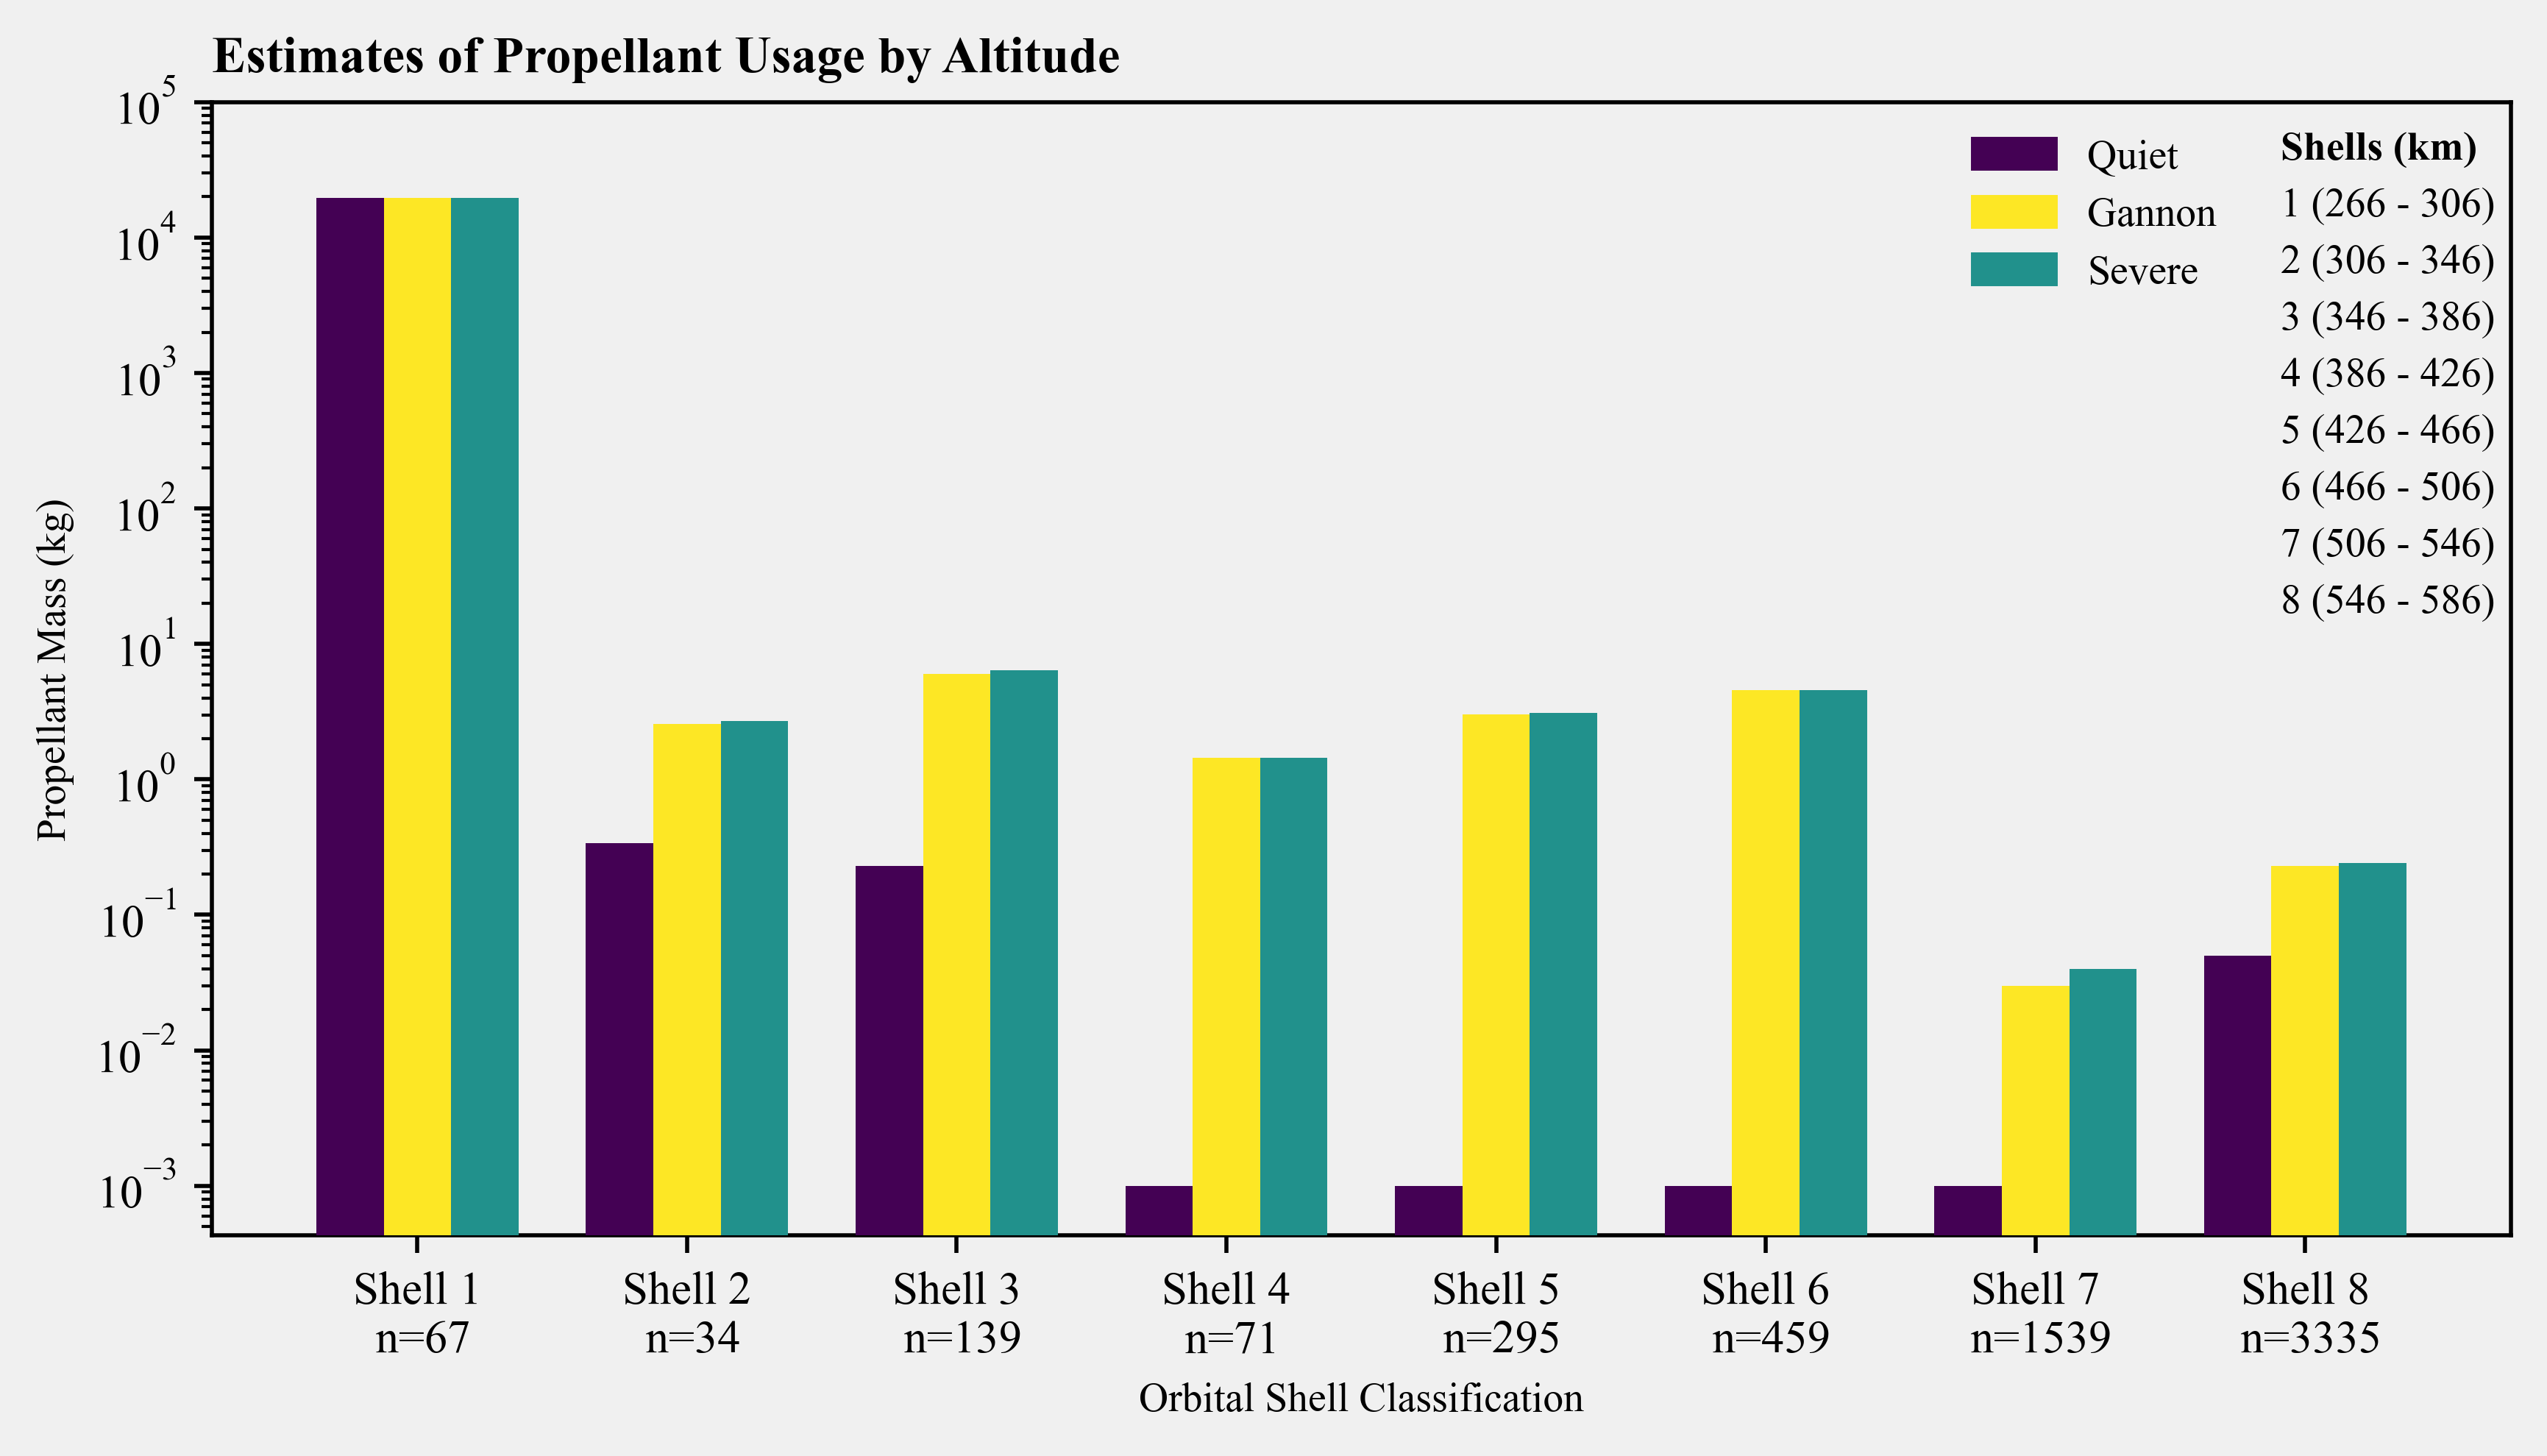

In [25]:
# Clean up data and labels
data = grouped_df.copy()
data['Quiet Propellant (kg)'] = data['Quiet Propellant (kg)'].replace(0.0, 0.001)
data['Actual Propellant (kg)'] = data['Actual Propellant (kg)'].replace(0.0, 0.01)
data['Storm Propellant (kg)'] = data['Storm Propellant (kg)'].replace(0.0, 0.01)

# Create simplified shell labels
altitude_bins = ["Shell 1", 'Shell 2', 'Shell 3', 'Shell 4', 'Shell 5', 'Shell 6', 'Shell 7', 'Shell 8']
# Add satellite counts to shell labels
altitude_bins = [
    f"{label}\n n={int(data['Satellite Count'].iloc[idx])}" 
    for idx, label in enumerate(altitude_bins)
]

# Setup plot with light grey background
fig = plt.figure(figsize=(10, 4), dpi=500)
plt.rcParams.update({'font.size': 10})

ax = plt.gca()
ax.set_facecolor('#f0f0f0')
fig.patch.set_facecolor('#f0f0f0')

# Add grid first
# ax.grid(True, axis='y', which='major', linestyle='-', alpha=0.3, zorder=0)

colors = ['#440154', '#FDE725', '#21918c']
x = np.arange(len(altitude_bins))
width = 0.25

# Plot bars
quiet = ax.bar(x - width, data['Quiet Propellant (kg)'], width, label='Quiet', 
              color=colors[0], zorder=3)
actual = ax.bar(x, data['Actual Propellant (kg)'], width, label='Gannon', 
               color=colors[1], zorder=3)
storm = ax.bar(x + width, data['Storm Propellant (kg)'], width, label='Severe', 
              color=colors[2], zorder=3)

ax.tick_params(labelsize=9)
ax.set_xticks(x)
ax.set_xticklabels(altitude_bins)

ax.set_title("Estimates of Propellant Usage by Altitude", fontsize=10, fontweight="bold", loc="left")
ax.set_ylabel("Propellant Mass (kg)", fontsize=8)
ax.set_xlabel("Orbital Shell Classification", fontsize=8)

ax.set_yscale('log')
ax.set_ylim(0, 1e5)

# Create legend elements
legend_elements = [
   mpatches.Patch(color=colors[0], label='Quiet'),
   mpatches.Patch(color=colors[1], label='Gannon'),
   mpatches.Patch(color=colors[2], label='Severe')
]

ax.text(0.9, 0.95, 'Shells (km)', transform=ax.transAxes, fontsize=8, fontweight='bold')

# Add altitude range legend elements
altitude_ranges = [
    '1 (266 - 306)',
    '2 (306 - 346)',
    '3 (346 - 386)',
    '4 (386 - 426)',
    '5 (426 - 466)',
    '6 (466 - 506)',
    '7 (506 - 546)',
    '8 (546 - 586)'
]

# Altitude ranges text
y_pos = 0.90
for alt_range in altitude_ranges:
   ax.text(0.9, y_pos, alt_range, transform=ax.transAxes, fontsize=8)
   y_pos -= 0.05

# Add the combined legend
ax.legend(handles=legend_elements, bbox_to_anchor=(0.75, 1), 
        loc='upper left', frameon=False, fontsize=8)

# Adjust layout
plt.subplots_adjust(right=0.75)
fig.savefig("figures/propellant_analysis.png", dpi=300, bbox_inches='tight', 
           facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

### Geospatial and Network Capacity Model

In [27]:
# Load state gdf
states_gdf_path =  "data/tl_2022_us_state.zip"
states_gdf = gpd.read_file(states_gdf_path)\

# Filter for the continental US (exclude Alaska, Hawaii, territories)
continental_us_states = states_gdf[~states_gdf['STATEFP'].isin(['02', '15', '72'])]  # Alaska, Hawaii, Puerto Rico

# As EPSG 4326
continental_us_states.to_crs(epsg=4326, inplace=True)

Loading existing CONUS H3 grid from data/h3_grid_conus_res5.gpkg
Loading CONUS states...


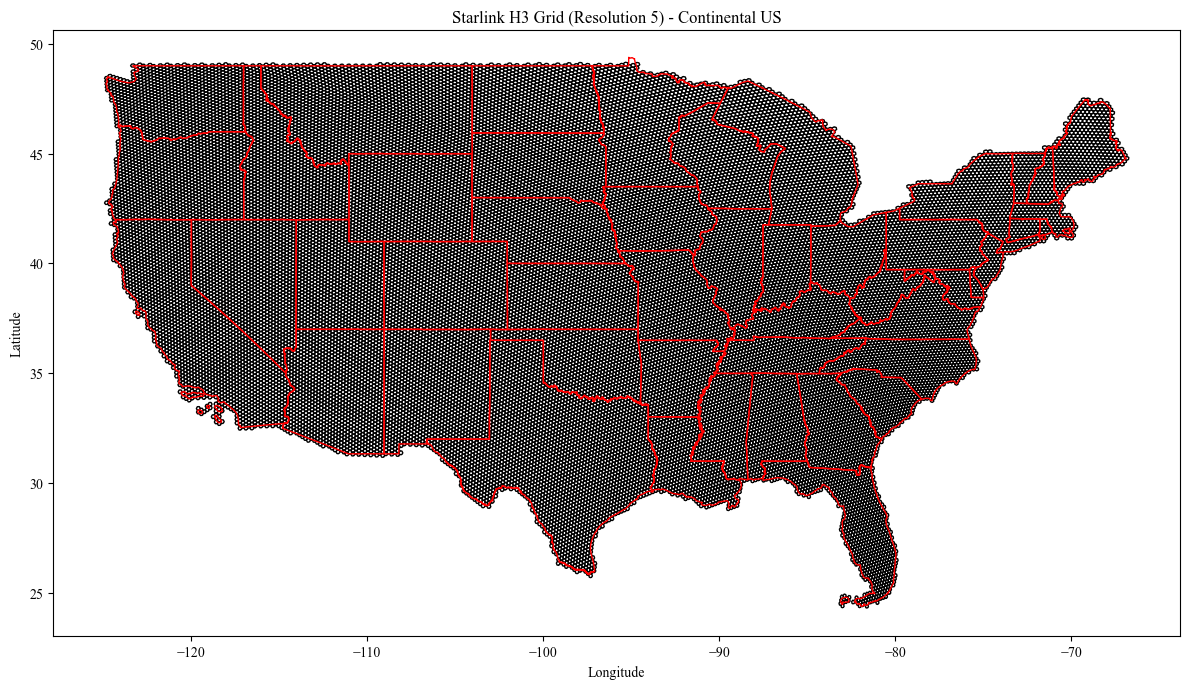

In [28]:
def process_h3_grid(bbox, h3_resolution=5, base_path="data", force_regenerate=False):
    """
    Generate or load H3 grid for continental US with specified resolution.

    Args:
        bbox: Tuple of (min_lon, min_lat, max_lon, max_lat) for bounding box
        h3_resolution: H3 grid resolution level (default: 5)
        base_path: Directory path for data files (default: "data")
        force_regenerate: Flag to force grid regeneration (default: False)

    Returns:
        tuple: (continental_hex_gdf, continental_us_states) containing:
            - GeoDataFrame of H3 hexagons intersecting continental US
            - GeoDataFrame of continental US state boundaries
    """
    # Define file paths
    h3_grid_path = f"{base_path}/h3_grid_res{h3_resolution}.gpkg"
    conus_grid_path = f"{base_path}/h3_grid_conus_res{h3_resolution}.gpkg"
    
    # Function to generate H3 hexagons in bounding box
    def generate_hexagons_in_bbox(bbox, resolution):
        hexagons = set()
        min_lon, min_lat, max_lon, max_lat = bbox
        for lat in range(int(min_lat * 1e6), int(max_lat * 1e6), 10000):
            for lon in range(int(min_lon * 1e6), int(max_lon * 1e6), 10000):
                hex_id = h3.latlng_to_cell(lat / 1e6, lon / 1e6, resolution)
                hexagons.add(hex_id)
        return hexagons
    
    # Function to generate initial H3 grid
    def generate_initial_grid():
        print("Generating initial H3 grid...")
        hex_ids = generate_hexagons_in_bbox(bbox, h3_resolution)
        hex_polygons = [Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(h)]) for h in hex_ids]
        return gpd.GeoDataFrame({'geometry': hex_polygons}, crs="EPSG:4326")
    
    # Function to get continental US states
    def get_conus_states():
        print("Loading CONUS states...")
        states_gdf = gpd.read_file("data/tl_2022_us_state.zip")
        continental_us_states = states_gdf[~states_gdf['STUSPS'].isin([
            'AK', 'HI', 'VI', 'MP', 'GU', 'AS', 'PR'
        ])]
        continental_us_states.to_crs(epsg=4326, inplace=True)
        return continental_us_states
    
    # Try to load existing CONUS grid first
    if not force_regenerate and os.path.exists(conus_grid_path):
        try:
            print(f"Loading existing CONUS H3 grid from {conus_grid_path}")
            continental_hex_gdf = gpd.read_file(conus_grid_path)
            return continental_hex_gdf, get_conus_states()
        except Exception as e:
            print(f"Error loading existing CONUS grid: {e}")
            print("Proceeding to regenerate...")
    
    # Try to load existing initial grid
    if not force_regenerate and os.path.exists(h3_grid_path):
        try:
            print(f"Loading existing H3 grid from {h3_grid_path}")
            hex_gdf = gpd.read_file(h3_grid_path)
        except Exception as e:
            print(f"Error loading existing grid: {e}")
            hex_gdf = generate_initial_grid()
    else:
        hex_gdf = generate_initial_grid()
    
    # Save initial grid if it doesn't exist
    if not os.path.exists(h3_grid_path):
        try:
            print(f"Saving H3 grid to {h3_grid_path}")
            hex_gdf.to_file(h3_grid_path, driver="GPKG")
        except Exception as e:
            print(f"Error saving H3 grid: {e}")
    
    # Get continental US states
    continental_us_states = get_conus_states()
    
    # Get the boundary of continental US
    us_boundary = continental_us_states.geometry.union_all()
    
    # Spatial join to get H3 cells that intersect with continental US
    print("Performing spatial join with CONUS boundary...")
    continental_hex_gdf = gpd.sjoin(
        hex_gdf, 
        gpd.GeoDataFrame(geometry=[us_boundary], crs="EPSG:4326"),
        predicate='intersects'
    )
    
    # Save CONUS grid
    try:
        print(f"Saving CONUS H3 grid to {conus_grid_path}")
        continental_hex_gdf.to_file(conus_grid_path, driver="GPKG")
    except Exception as e:
        print(f"Error saving CONUS grid: {e}")
    
    return continental_hex_gdf, continental_us_states

# Use the function
bbox = (-125, 24, -66, 49)  # min_lon, min_lat, max_lon, max_lat
continental_hex_gdf, continental_us_states = process_h3_grid(
    bbox=bbox,
    h3_resolution=5,
    force_regenerate=False  # Set to True to force regeneration
)

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
continental_us_states.boundary.plot(ax=ax, color='red', linewidth=1)
continental_hex_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
plt.title('Starlink H3 Grid (Resolution 5) - Continental US')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

### Load the socio-economic data

In [29]:
# Read and prepare initial datasets
data_zcta_path = "data/NAICS_EST_GDP2022_ZCTA.csv"
population_df_path = "data/2020_decennial_census_at_ZCTA_level.csv"

# Load ZCTA data and convert ZIP codes to integers
data_zcta = pd.read_csv(data_zcta_path)
data_zcta["ZCTA"] = data_zcta["ZCTA"].astype(int)

# Load population data and convert ZIP codes to integers
population_df = pd.read_csv(population_df_path)
population_df["ZCTA"] = population_df["ZCTA"].astype(int)

# Process unique ZCTA regions and merge with population data
unique_zcta_regions = data_zcta[["ZCTA", "REGIONS", "STABBR"]].drop_duplicates()
regions_pop_df = unique_zcta_regions.merge(population_df, on=["ZCTA", "STABBR"])

def optimized_zcta_processing(data_zcta):
    """
    Process ZCTA (ZIP Code Tabulation Areas) data using Dask for large datasets.

    Args:
        data_zcta: DataFrame containing ZCTA business and economic data
    
    Returns:
        GeoDataFrame: Processed ZCTA data with geometries and business info
    """
    # Load ZCTA shapefile using dask_geopandas
    zcta_gdf = dask_geopandas.read_file("data/tl_2020_us_zcta520.zip", npartitions=10)
    
    # Ensure CRS is WGS84
    if zcta_gdf.crs != "EPSG:4326":
        zcta_gdf = zcta_gdf.to_crs("EPSG:4326")
    
    # Standardize column names and data types
    zcta_gdf = zcta_gdf.rename(columns={"ZCTA5CE20": "ZCTA"})
    zcta_gdf['ZCTA'] = zcta_gdf['ZCTA'].astype(int)
    
    # Convert input to dask DataFrame if needed
    if not isinstance(data_zcta, dd.DataFrame):
        data_zcta = dd.from_pandas(data_zcta, npartitions=10)
        data_zcta['ZCTA'] = data_zcta['ZCTA'].astype(int)
    
    # Merge business data with geometries
    zcta_business_gdf = data_zcta.merge(zcta_gdf[['ZCTA', 'geometry']], on='ZCTA', how='inner')
    
    return zcta_business_gdf.compute()

# Process ZCTA data and convert GDP to daily values
zcta_business_gdf = optimized_zcta_processing(data_zcta)
zcta_business_gdf['GDP2022'] = (zcta_business_gdf['GDP2022'] * 1000) / 365
zcta_business_gdf = gpd.GeoDataFrame(zcta_business_gdf, geometry="geometry")

In [30]:
def process_full_dataset(regions_pop_df, zcta_business_gdf, continental_hex_gdf, h3_stats_file="data/h3_stats.pkl"):
    """
    Intersect socio-economic data with H3 cells and calculate population and business statistics.
    Assign populations and businesses to each cell based on area proportion

    Args:
        regions_pop_df: DataFrame containing regional population data
        zcta_business_gdf: GeoDataFrame containing ZCTA business data
        continental_hex_gdf: GeoDataFrame containing H3 hexagons
        h3_stats_file: Path to save/load processed stats (default: "data/h3_stats.pkl")

    Returns:
        dict: H3 cell statistics with population and NAICS data
            Format: {
                hex_id: {
                    'pop': population count,
                    'naics_stats': {
                        naics_code: {
                            'est': establishment count,
                            'gdp': GDP value
                        }
                    }
                }
            }
    """
    if os.path.exists(h3_stats_file):
        print("Loading existing H3 stats...")
        with open(h3_stats_file, 'rb') as f:
            return pickle.load(f)
    
    h3_stats = {
        hex_id: {
            'pop': 0,
            'naics_stats': {}
        } for hex_id in continental_hex_gdf.index
    }
    
    for zcta_id in tqdm(regions_pop_df.ZCTA.unique()):
        zcta_businesses = zcta_business_gdf[zcta_business_gdf.ZCTA == zcta_id]
        if len(zcta_businesses) == 0:
            continue
            
        zcta_geom = zcta_businesses.iloc[0].geometry
        zcta_area = zcta_geom.area
        
        intersecting_cells = continental_hex_gdf[continental_hex_gdf.geometry.intersects(zcta_geom)]
        if len(intersecting_cells) == 0:
            continue
        
        intersection_areas = {}
        for cell_id, cell in intersecting_cells.iterrows():
            intersection = cell.geometry.intersection(zcta_geom)
            intersection_areas[cell_id] = intersection.area / zcta_area
        
        zcta_pop = regions_pop_df.loc[regions_pop_df.ZCTA == zcta_id, 'POP20'].iloc[0]
        
        for cell_id, area_proportion in intersection_areas.items():
            h3_stats[cell_id]['pop'] += zcta_pop * area_proportion
            
            for _, business in zcta_businesses.iterrows():
                naics = business.NAICS
                if naics not in h3_stats[cell_id]['naics_stats']:
                    h3_stats[cell_id]['naics_stats'][naics] = {'est': 0, 'gdp': 0}
                
                h3_stats[cell_id]['naics_stats'][naics]['est'] += business.EST * area_proportion
                h3_stats[cell_id]['naics_stats'][naics]['gdp'] += business.GDP2022 * area_proportion
    
    print("Saving results...")
    with open(h3_stats_file, 'wb') as f:
        pickle.dump(h3_stats, f)
    
    return h3_stats

h3_stats = process_full_dataset(regions_pop_df, zcta_business_gdf, continental_hex_gdf)

Loading existing H3 stats...


In [31]:
def distribute_starlink_users(h3_stats, total_users=1_400_000):
    """
    Distribute Starlink users across H3 cells inversely proportional to population.

    Args:
        h3_stats: Dictionary of H3 cell statistics containing population data
        total_users: Total number of users to distribute (default: 1.4M)

    Returns:
        dict: Number of users allocated to each H3 cell
    """
    # Calculate inverse population weights
    weights = {}
    for cell in h3_stats:
        if h3_stats[cell]['pop'] > 0:
            weights[cell] = 1 / h3_stats[cell]['pop']
        else:
            weights[cell] = 0
            
    # Normalize weights
    total_weight = sum(weights.values())
    normalized_weights = {cell: weight / total_weight for cell, weight in weights.items()}
    
    # Allocate integer number of users based on weights
    users_per_cell = {
        cell: int(normalized_weights[cell] * total_users) for cell in h3_stats
    }
    
    # Handle remaining users from rounding
    total_assigned = sum(users_per_cell.values())
    remainder = total_users - total_assigned
    
    # Calculate fractional weights for remainder distribution
    fractional_weights = {
        cell: (normalized_weights[cell] * total_users) % 1 for cell in h3_stats
    }
    
    # Distribute remainder to cells with highest fractional weights
    sorted_cells = sorted(fractional_weights, key=fractional_weights.get, reverse=True)
    for cell in sorted_cells[:remainder]:
        users_per_cell[cell] += 1
        
    assert sum(users_per_cell.values()) == total_users
    return users_per_cell

users_per_cell = distribute_starlink_users(h3_stats)

In [32]:
# Check for stats DataFrame
if os.path.exists('stats_df.csv'):
    print("Loading existing stats DataFrame...")
    stats_df = pd.read_csv('stats_df.csv')
else:
    print("Generating new stats DataFrame...")
    # Convert stats to DataFrame for easier handling
    cell_stats = []
    for cell_id, stats in h3_stats.items():
        cell_data = {
            'cell_id': cell_id,
            'population': stats['pop'],
            'total_est': sum(naics_stat['est'] for naics_stat in stats['naics_stats'].values()),
            'total_gdp': sum(naics_stat['gdp'] for naics_stat in stats['naics_stats'].values())
        }
        # Add individual NAICS stats
        for naics, naics_stats in stats['naics_stats'].items():
            cell_data[f'est_{naics}'] = naics_stats['est']
            cell_data[f'gdp_{naics}'] = naics_stats['gdp']
        cell_stats.append(cell_data)
    
    stats_df = pd.DataFrame(cell_stats)
    stats_df.to_csv('stats_df.csv', index=False)
    print("Stats DataFrame saved.")

stats_df['starlink_users'] = stats_df['cell_id'].map(users_per_cell)

# Add stats back to H3 GeoDataFrame
continental_hex_gdf = continental_hex_gdf.merge(
    stats_df, 
    left_index=True, 
    right_on='cell_id'
)

Loading existing stats DataFrame...


## Input-Output Model.
It gets the indirect impact given direct demand shocks

In [33]:
class InputOutputModel:

    def __init__(self, data_path, value_added=None, final_demand=None):
        self.final_demand = final_demand
        self.value_added = value_added
        self.data_path = data_path
        self.load_input_data()
        self.calculate_B_matrix()

    def load_input_data(self):
        """
        Load the input data.

        Parameters:
        None
        """

        # Technical coefficients matrix
        self.technology_matrix = pd.read_csv(
            os.path.join(self.data_path, "direct_requirements.csv")
        )

        # A matrix (trim the value added in the io matrix)
        self.A = self.technology_matrix.iloc[:15].to_numpy()

        # Identity matrix
        self.I = np.eye(self.A.shape[1])

        # Real 2022 US gross output by industires, in billion dollars
        self.industry_output = pd.read_csv(
            os.path.join(self.data_path, "us_gross_output.csv"), usecols=["2022Q3"]
        ).to_numpy().reshape(-1)

    def calculate_B_matrix(self):
        # Diagonalize the industry output (x_hat)
        gross_diag = np.diag(self.industry_output)

        # Invverse of the diagonalized industry output (x_hat^-1)
        gross_diag_inv = np.linalg.inv(gross_diag)

        # Compute the B matrix
        self.B = np.dot(np.dot(gross_diag_inv, self.A), gross_diag)

    def leontief(self):
        """
        Calculate the Leontief model.
        L = (I - A)^-1 add X = L * final_demand

        Parameters:
        final_demand (numpy.ndarray): The final demand vector.

        Returns:
        numpy.ndarray: The output vector representing the total output of each sector.
        """

        if (self.final_demand.any()):
            return np.linalg.inv(self.I - self.A).dot(self.final_demand)

    def ghosh(self):
        """
        Calculate the supply chain impacts due to change in value added.
        B = X_hat^-1 * A * X_hat and Ghosh = (I - B)^-1
        Change in Gross output is v' @ Ghosh

        Parameters:
        None

        Returns:
        numpy.ndarray: The total downstream impacts.
        """
        if (self.value_added.any()):

            # Ghosh model
            self.ghosh_model = np.linalg.inv(self.I - self.B)

            # Transpose value added
            va_transposed = np.transpose(self.value_added)

            # Change in Gross output is v' @ Ghosh
            delta_va = va_transposed @ self.ghosh_model

            return delta_va

In [34]:
regions_pop_df.head(5)

ZCTA REGIONS STABBR  STATE             ZIPNAME  POP20   AFACT
0  35004   SERTP     AL      1           Moody, AL  11477  0.0023
1  35005   SERTP     AL      1      Adamsville, AL   7578  0.0015
2  35007   SERTP     AL      1       Alabaster, AL  28274  0.0056
3  35010   SERTP     AL      1  Alexander City, AL  20271  0.0040
4  35016   SERTP     AL      1            Arab, AL  17495  0.0035

## Satellite Visibility and Coverage Analysis

In [35]:
def haversine_distance_and_components(lat1, lon1, lat2, lon2):
    """
    Calculate great-circle distance between two points using Haversine formula.

    Args:
        lat1: Latitude of first point (degrees)
        lon1: Longitude of first point (degrees)
        lat2: Latitude of second point (degrees)
        lon2: Longitude of second point (degrees)
    
    Returns:
        float: Distance between points in kilometers
    """
    R = 6371  # Earth's radius in km
    
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Calculate differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

def get_conus_centroid():
    """
    Calculate the centroid of continental United States.

    Returns:
        tuple: (latitude, longitude) of CONUS centroid
    """
    conus_centroid = continental_us_states.geometry.unary_union.centroid
    center_lat, center_lon = conus_centroid.y, conus_centroid.x
    return center_lat, center_lon

# Calculate median satellite heights and create altitude bins
median_heights = np.asarray([sat["median_altitude"] for sat in starlink_alts.values()])
min_altitude = np.nanmin(median_heights)
max_altitude = np.nanmax(median_heights)
bins = np.linspace(min_altitude, max_altitude, 9)  # 8 bins, 9 edges

# Get CONUS center coordinates
center_lat, center_lon = get_conus_centroid()

In [36]:
def calculate_elevation(ground_distance, altitude, R=6371):
    """
    Calculate satellite elevation angle from ground point using spherical geometry.

    Args:
        ground_distance: Great circle distance in km between ground point and satellite nadir
        altitude: Satellite altitude in km
        R: Earth radius in km (default: 6371)

    Returns:
        float: Elevation angle in degrees
        None: If satellite is beyond maximum visibility distance
    """
    # Calculate maximum possible ground distance for this altitude
    Rs = R + altitude
    max_ground_distance = R * np.arccos(R/Rs)
    
    if ground_distance > max_ground_distance:
        return None
    
    # Convert ground distance to central angle
    central_angle = ground_distance / R
    
    # Calculate slant range using law of cosines
    slant_range = np.sqrt(R**2 + Rs**2 - 2*R*Rs*np.cos(central_angle))
    
    # Calculate angle between radius and slant height
    cos_theta_prime = (R**2 + slant_range**2 - Rs**2) / (2 * R * slant_range)
    theta_prime = np.degrees(np.arccos(cos_theta_prime))
    
    # Calculate elevation angle
    elevation = theta_prime - 90
    return elevation

def check_visibility_across_us(t, starlink_sats, bins, min_elevation=25):
    """
    Check satellite visibility across continental US grid points.

    Args:
        t: Time index for satellite positions
        starlink_sats: Dictionary of satellite data with positions and altitudes
        bins: Altitude bin edges for grouping satellites
        min_elevation: Minimum elevation angle in degrees (default: 25)

    Returns:
        dict: Satellites visible from US grouped by altitude plane
            {plane_index: [{sat_id, lat, lon}, ...]}
    """
    # Create grid points across continental US
    lat_points = np.linspace(25, 49, 20)
    lon_points = np.linspace(-125, -67, 30)
    
    visible_by_plane = {i: [] for i in range(len(bins)-1)}
    
    for sat_id, sat_data in starlink_sats.items():
        median_alt = starlink_sats[sat_id]["median_altitude"]
        plane_idx = np.digitize(median_alt, bins) - 1
        
        # Ensure plane index is within bounds
        plane_idx = min(max(plane_idx, 0), len(bins)-2)
        
        # Get satellite position
        sat_lat = sat_data['latitudes'][t]
        sat_lon = sat_data['longitudes'][t]
        
        # Check visibility from grid points
        visible = False
        for lat in lat_points:
            for lon in lon_points:
                ground_distance = haversine_distance_and_components(
                    lat, lon, sat_lat, sat_lon
                )
                elevation = calculate_elevation(ground_distance, median_alt)
                
                if elevation is not None and elevation >= min_elevation:
                    visible = True
                    break
            if visible:
                break
                
        if visible:
            visible_by_plane[plane_idx].append({
                'sat_id': sat_id,
                'lat': sat_lat,
                'lon': sat_lon
            })
    
    return visible_by_plane

## Propagate visibilities within 24 hours
Get's the average number of satellites visible across CONUS

In [37]:
def analyze_all_timestamps(starlink_sats, bins, n, save_path='visibility_analysis.pkl'):
   """
   Analyze satellite visibility across continental US for multiple timestamps.

   Args:
       starlink_sats: Dictionary of satellite data with positions and altitudes 
       bins: Altitude bin edges for grouping satellites
       n: Number of timestamps to analyze
       save_path: Path to save/load analysis results (default: 'visibility_analysis.pkl')

   Returns:
       list: Analysis results for each timestamp containing:
           {
               'timestamp': time index,
               'planes': {
                   plane_idx: {
                       'altitude_range': (min_alt, max_alt),
                       'num_satellites': count of visible sats,
                       'coverage_radius': coverage in km,
                       'satellites': [{sat_id, lat, lon}, ...]
                   }
               }
           }
   """
   if os.path.exists(save_path):
       print("Loading existing analysis...")
       with open(save_path, 'rb') as f:
           return pickle.load(f)
       print("Loading finished...")
   
   print("Generating new visibility analysis...")
   visibility_data = []
   timestamps = np.linspace(0, n, 20, dtype=int)
   
   for t in tqdm(timestamps):
       try:
           time_data = {
               'timestamp': t,
               'planes': {}
           }
           
           # Verify timestamp validity
           valid_timestamp = False
           for sat_id, sat_data in starlink_sats.items():
               if t < len(sat_data['times']):
                   valid_timestamp = True
                   break
           
           if not valid_timestamp:
               print(f"\nSkipping timestamp {t} - beyond data range")
               continue
               
           # Get visibility data
           try:
               visibility = check_visibility_across_us(t, starlink_sats, bins)
           except IndexError:
               print(f"\nIndex error for timestamp {t}, skipping...")
               continue
           
           # Process each altitude plane
           for plane_idx, sats in visibility.items():
               bin_min, bin_max = bins[plane_idx], bins[plane_idx + 1]
               
               plane_data = {
                   'altitude_range': (bin_min, bin_max),
                   'num_satellites': len(sats),
                   'coverage_radius': calculate_coverage_radius((bin_min + bin_max)/2) if sats else 0,
                   'satellites': sats
               }
               
               time_data['planes'][plane_idx] = plane_data
           
           visibility_data.append(time_data)
           
       except Exception as e:
           print(f"\nError processing timestamp {t}: {str(e)}")
           continue
   
   if visibility_data:
       print("\nSaving analysis...")
       with open(save_path, 'wb') as f:
           pickle.dump(visibility_data, f)
       print("Analysis complete!")
   else:
       print("\nNo valid data to save!")
   
   return visibility_data

# Analyze timestamps using first satellite's time data length
n = len(list(starlink_sats.items())[1][1]['times'])
visibility_data = analyze_all_timestamps(starlink_sats, bins, n)
print("Loading finished...")

Loading existing analysis...
Loading finished...


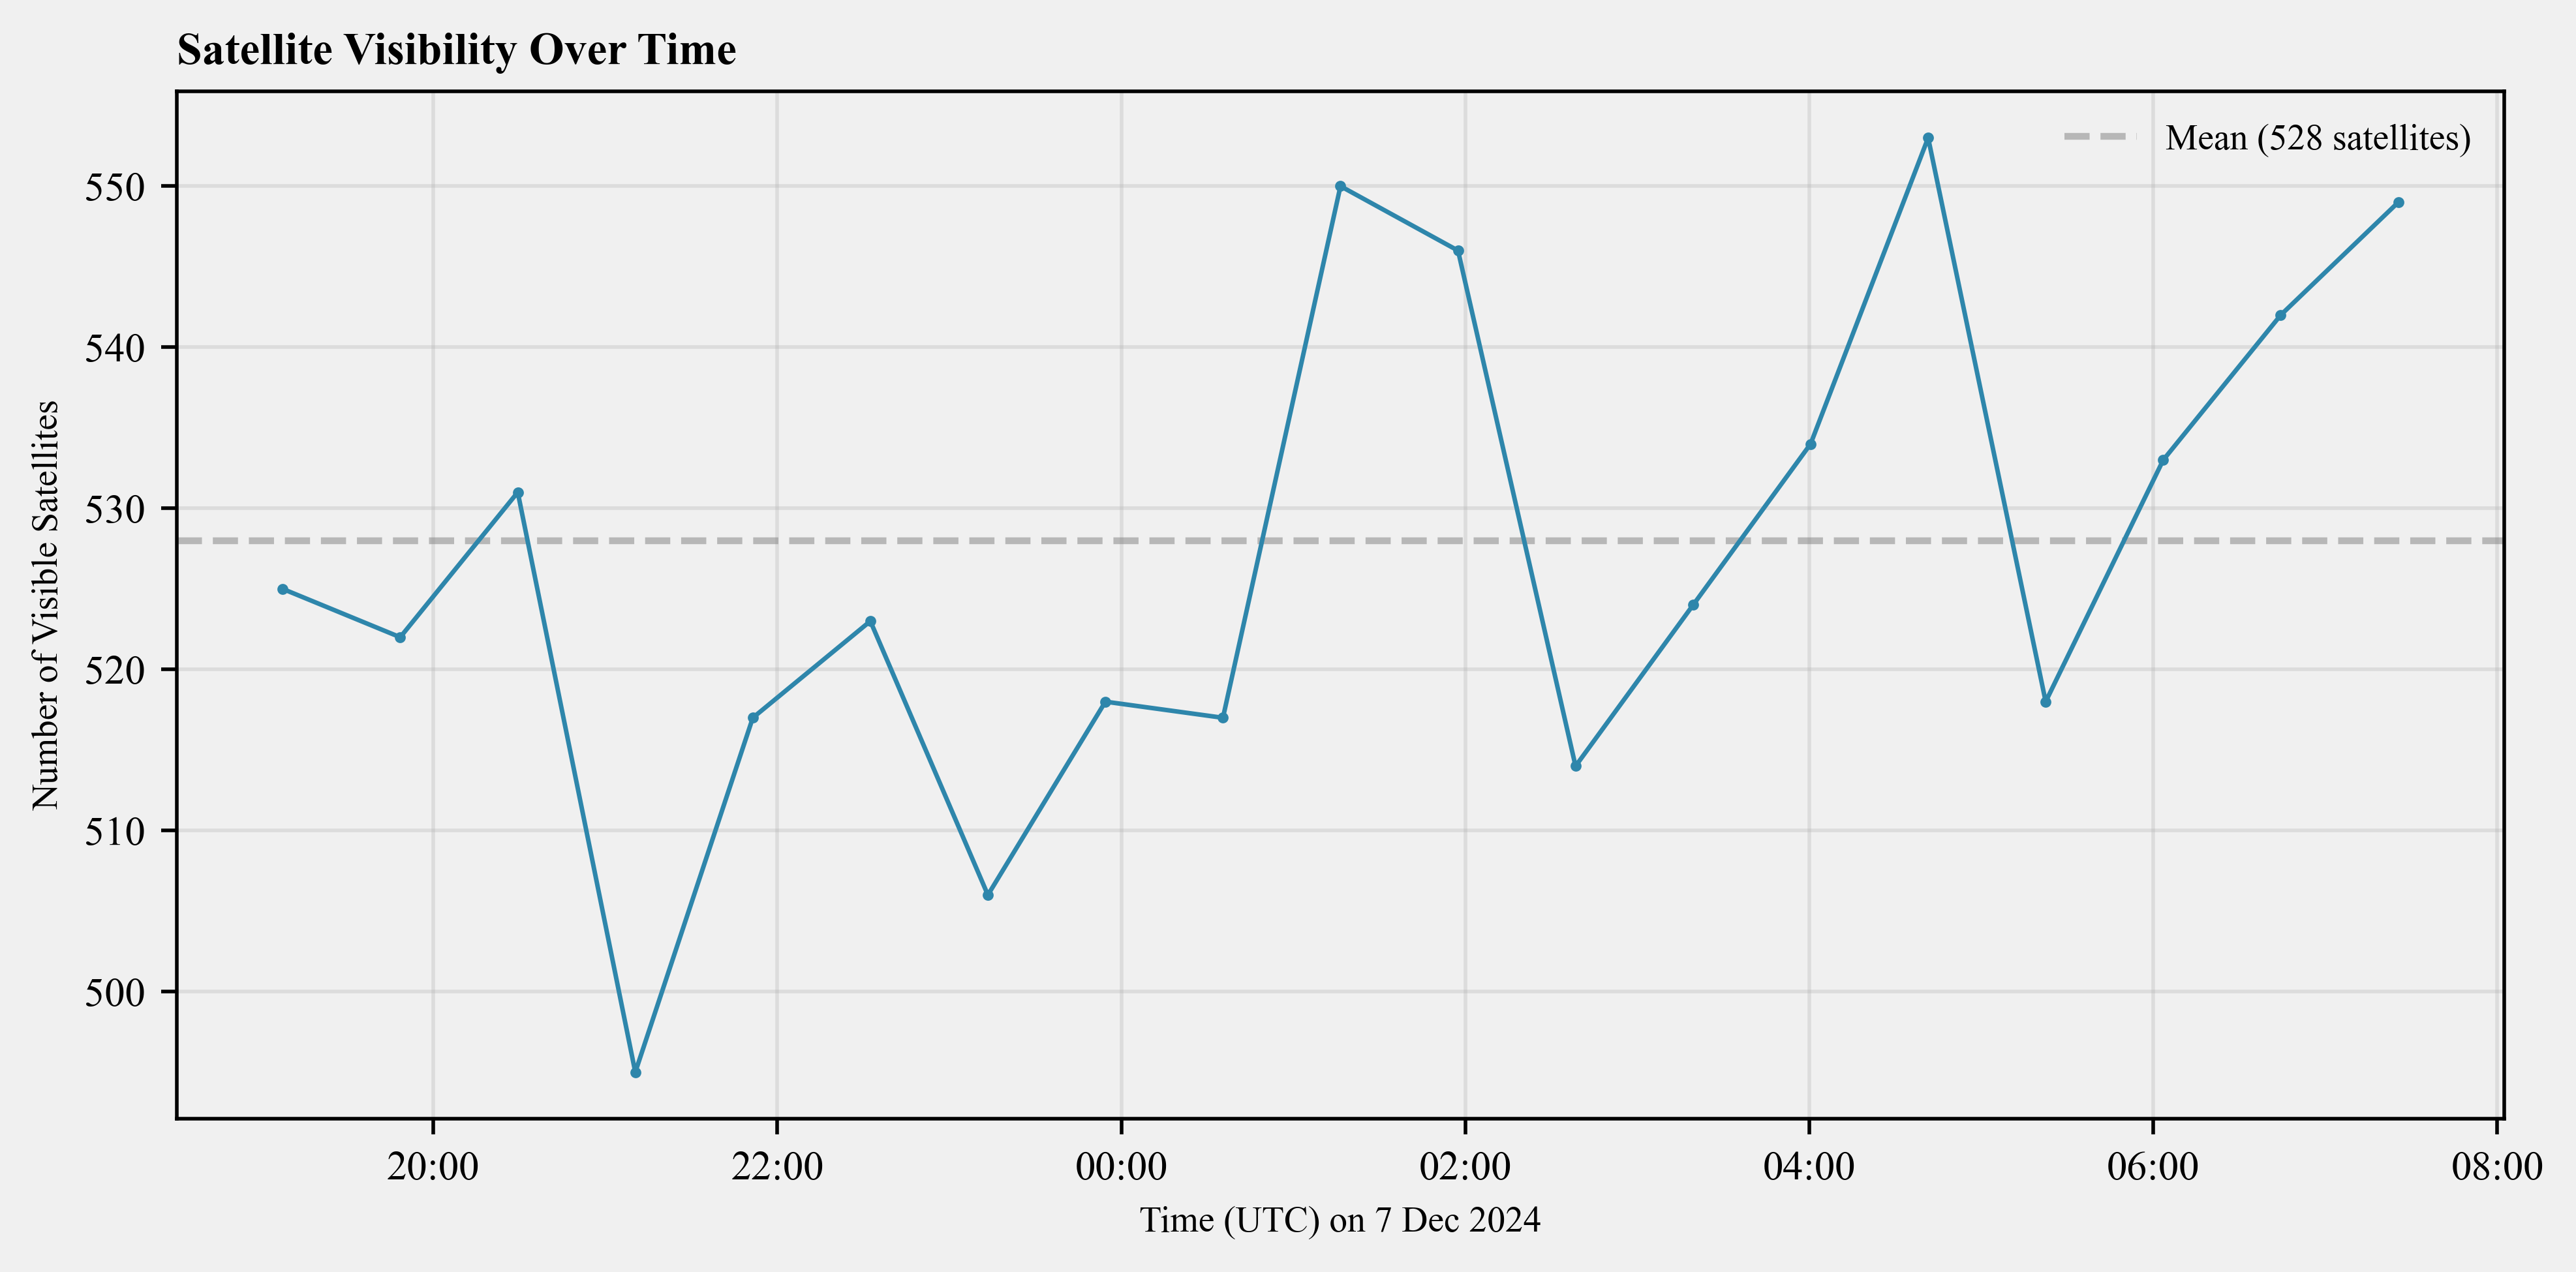

In [38]:
n = len(list(starlink_sats.items())[1][1]['times'])
time_indices = np.linspace(0, n-1, 20, dtype=int)  # Changed n to n-1
satellite_times = [list(starlink_sats.items())[1][1]['times'][i] for i in time_indices]

satellite_counts = []
for time_data, timestamp in zip(visibility_data, satellite_times):
    total_sats = sum(plane_data['num_satellites'] 
                    for plane_data in time_data['planes'].values())
    satellite_counts.append({
        'timestamp': timestamp,
        'total_satellites': total_sats 
    })

# Plotting code
visibility_df = pd.DataFrame(satellite_counts)
visible_sats = np.ceil(visibility_df['total_satellites'].mean())

# Setup plot with styling
fig = plt.figure(figsize=(8, 4), dpi=500)
plt.rcParams.update({'font.size': 10})
ax = plt.gca()
ax.set_facecolor('#f0f0f0')
fig.patch.set_facecolor('#f0f0f0')
ax.grid(True, which='major', linestyle='-', alpha=0.3, zorder=0)

visibility_line = ax.plot(visibility_df['timestamp'], 
                         visibility_df['total_satellites'], 
                         color='#2E86AB', 
                         linewidth=1,
                         zorder=3)

ax.scatter(visibility_df['timestamp'], 
          visibility_df['total_satellites'],
          color='#2E86AB', 
          s=2,
          zorder=4)

mean_line = ax.axhline(y=visible_sats, 
                       color='gray',
                       linestyle='--',
                       alpha=0.5,
                       label=f'Mean ({int(visible_sats)} satellites)',
                       zorder=2)

ax.tick_params(labelsize=9)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xticks(rotation=0)

ax.set_title("Satellite Visibility Over Time", fontsize=10, fontweight="bold", loc="left")
ax.set_xlabel("Time (UTC) on 7 Dec 2024", fontsize=8)
ax.set_ylabel("Number of Visible Satellites", fontsize=8)

ax.legend(frameon=False, loc='upper right', fontsize=8)
plt.tight_layout()

fig.savefig("figures/satellite_visibility.png", dpi=300, bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [39]:
# Convert H3 grid to line segments
def get_line_segments(gdf):
    line_segments = []
    for geometry in gdf.geometry:
        coords = list(geometry.exterior.coords)
        # Create line segments from coordinates
        for i in range(len(coords)-1):
            line_segments.append([coords[i], coords[i+1]])
    return line_segments

# Get line segments
line_segments = get_line_segments(continental_hex_gdf)

In [40]:
from shapely.geometry import box
small_bbox = (-100, 35, -95, 40)  # Example smaller region (min_lon, min_lat, max_lon, max_lat)

# Function to filter the hex grid to the smaller region
def filter_hex_by_bbox(hex_gdf, bbox):
    min_lon, min_lat, max_lon, max_lat = bbox
    region_geom = box(min_lon, min_lat, max_lon, max_lat)
    region_gdf = gpd.GeoDataFrame({'geometry': [region_geom]}, crs="EPSG:4326")
    filtered_hex = gpd.sjoin(hex_gdf, region_gdf, predicate='intersects')
    return filtered_hex

# Rename conflicting column in hex_gdf
if 'index_right' in continental_hex_gdf.columns:
    continental_hex_gdf = continental_hex_gdf.rename(columns={'index_right': 'existing_index_right'})

# Filter to smaller region
small_region_hex_gdf = filter_hex_by_bbox(continental_hex_gdf, small_bbox)
line_segments_region =  get_line_segments(small_region_hex_gdf)

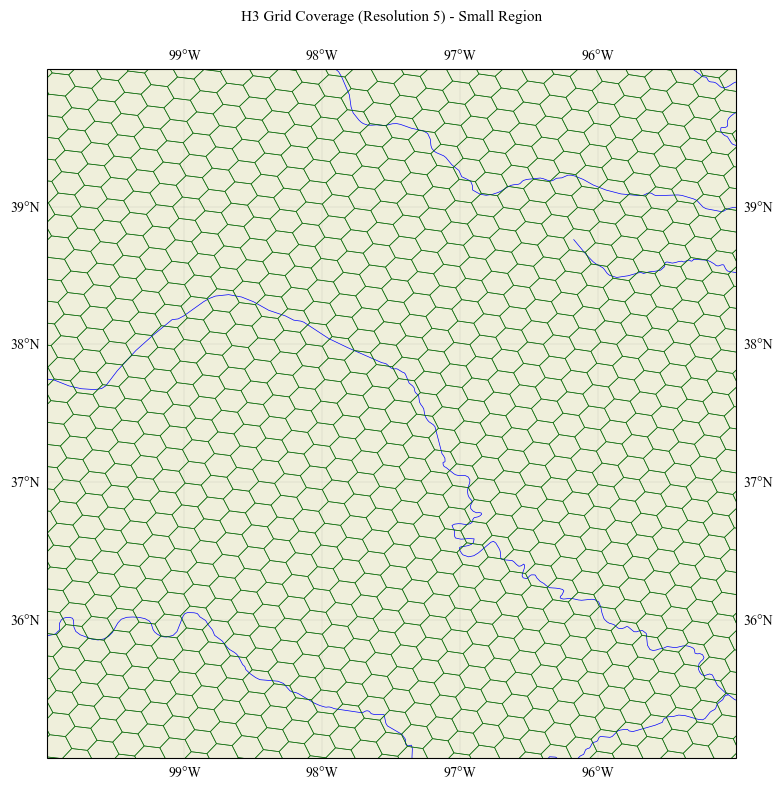

In [41]:
# Function to set up the basemap
def setup_map_h3(ax):
    # Add features to the basemap
    ax.add_feature(cfeature.LAND, edgecolor='black', zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, zorder=1)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue', zorder=0)
    ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=0.5, zorder=1)
    ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
    ax.set_extent([small_bbox[0], small_bbox[2], small_bbox[1], small_bbox[3]], crs=ccrs.PlateCarree())  # Set the extent to the small_bbox

# Get line segments from the small region
line_segments_region = get_line_segments(small_region_hex_gdf)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Set up the map with a basemap
setup_map_h3(ax)

# Create and add the LineCollection for the H3 grid line segments
lc = LineCollection(
    line_segments_region,
    transform=ccrs.PlateCarree(),
    color='darkgreen',  # You can use a color palette or adjust as needed
    linewidth=0.5,
    alpha=0.8  # Adjust transparency if needed
)
ax.add_collection(lc)

# Add a title
ax.set_title('H3 Grid Coverage (Resolution 5) - Small Region', 
             pad=20, fontsize=11, fontweight='medium', loc='center')

# Save and display the plot
plt.tight_layout()
plt.savefig("figures/small_region_coverage_map.png", dpi=300, bbox_inches='tight')
plt.show()

### Visualize the cells and satellite coverage

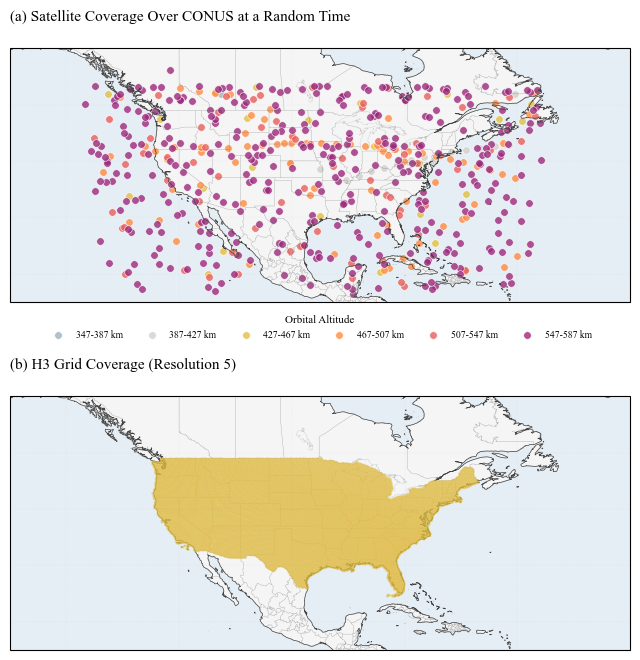

In [42]:
# Color palette for scientific visualization
COLORS = [
    "#2E5266",  # Deep blue
    "#6E8898",  # Steel blue
    "#9FB1BC",  # Light blue
    "#D3D0CB",  # Light gray
    "#E2C044",  # Gold
    "#FF8C42",  # Orange
    "#E85F5C",  # Coral
    "#9B287B",  # Purple
]

def setup_map(ax, spatial_extent=[-150, -40, 15, 60]):  # Tighter focus on CONUS
    ax.set_extent(spatial_extent, ccrs.PlateCarree())
    
    # Refined color scheme
    ax.add_feature(cfeature.LAND, facecolor="#F5F5F5")  # Lighter land
    ax.add_feature(cfeature.OCEAN, facecolor="#E6EEF5")  # Subtle blue ocean
    
    # More subtle state boundaries
    states = ax.add_feature(cfeature.STATES.with_scale('10m'), 
                           linewidth=0.25, 
                           edgecolor="#666666", 
                           alpha=0.3)
    
    # Refined coastlines
    ax.add_feature(cfeature.COASTLINE, 
                   linewidth=0.5, 
                   edgecolor="#444444")
    
    # Subtle gridlines
    gl = ax.gridlines(draw_labels=False, 
                      linewidth=0.2, 
                      color="#999999", 
                      alpha=0.3, 
                      linestyle=":")
    return ax


# Create figure
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)

# Top subplot - Satellite Coverage
ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
setup_map(ax1)

# Plot satellites
for plane_idx, data in visibility_data[10]['planes'].items():
    if data and data['satellites']:
        sats = data['satellites']
        lats = [sat['lat'] for sat in sats]
        lons = [sat['lon'] for sat in sats]
        
        color = COLORS[plane_idx % len(COLORS)]
        ax1.scatter(lons, lats, 
                   c=color,
                   s=30,
                   alpha=0.8,
                   marker='o',
                   edgecolor='white',
                   linewidth=0.5,
                   label=f'{bins[plane_idx]:.0f}-{bins[plane_idx+1]:.0f} km')

# Add legend at the bottom, horizontal orientation
ax1.legend(title='Orbital Altitude',
          bbox_to_anchor=(0.5, -0.1),  # Center below the plot
          loc='center',
          frameon=False,
          title_fontsize=8,
          fontsize=7,
          ncol=6)  # Number of columns for horizontal layout

ax1.set_title('(a) Satellite Coverage Over CONUS at a Random Time', 
              pad=20, 
              fontsize=11,
              fontweight='medium',
              loc='left')

# Bottom subplot - H3 Grid
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
setup_map(ax2)

# Create and add LineCollection
lc = LineCollection(line_segments, 
                   transform=ccrs.PlateCarree(),
                   color=COLORS[4],
                   linewidth=0.5,
                   alpha=0.5)
ax2.add_collection(lc)

ax2.set_title('(b) H3 Grid Coverage (Resolution 5)', 
              pad=20, fontsize=11, fontweight='medium', loc='left')

plt.tight_layout()
plt.savefig("figures/combined_coverage_maps.png", dpi=300, bbox_inches='tight')
plt.show()

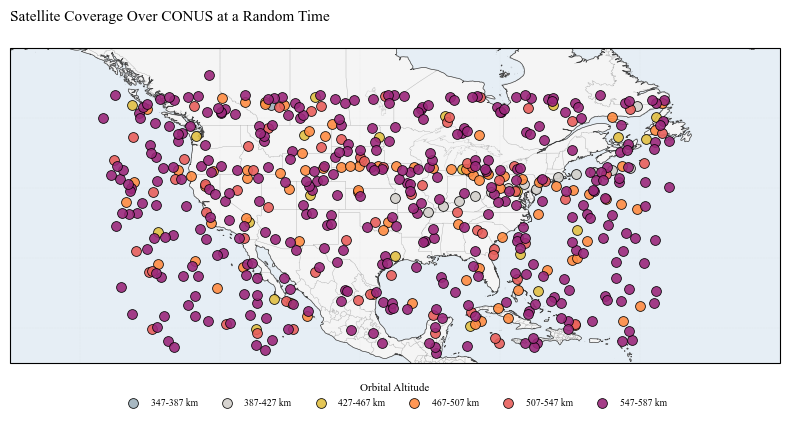

In [100]:
# Create figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set up the map
setup_map(ax)

# Plot satellite visibility with enhanced scatter aesthetics
for plane_idx, data in visibility_data[10]['planes'].items():
    if data and data['satellites']:
        sats = data['satellites']
        lats = [sat['lat'] for sat in sats]
        lons = [sat['lon'] for sat in sats]
        
        # Define scatter style
        color = COLORS[plane_idx % len(COLORS)]
        ax.scatter(
            lons, lats, 
            c=color,                     # Color by plane index
            s=50,                        # Slightly larger size for visibility
            alpha=0.9,                   # Make markers slightly less transparent
            marker='o',                  # Circular markers
            edgecolor='black',           # Add black edges for contrast
            linewidth=0.6,               # Edge thickness
            zorder=5,                    # Ensure scatter is above basemap
            label=f'{bins[plane_idx]:.0f}-{bins[plane_idx+1]:.0f} km'
        )

# Add legend for satellite data
ax.legend(
    title='Orbital Altitude',
    bbox_to_anchor=(0.5, -0.1),  # Center below the plot
    loc='center',
    frameon=False,
    title_fontsize=8,
    fontsize=7,
    ncol=6  # Arrange items in 6 columns
)

# Add title
ax.set_title(
    'Satellite Coverage Over CONUS at a Random Time', 
    pad=20, 
    fontsize=11, 
    fontweight='medium', 
    loc='left'
)

# Save and display the plot
plt.tight_layout()
plt.savefig("figures/satellite_visibility_map.png", dpi=300, bbox_inches='tight')
plt.show()

### Socio-economic impact analysis

In [43]:
# NAICS code and industry concordance
NAICSIndustries = {
    "11": "Agriculture, forestry, and fishing",
    "21": "Mining, quarrying, and gas extraction",
    "22": "Utilities",
    "23": "Construction",
    "31": "Manufacturing",
    "42": "Wholesale Trade",
    "44": "Retail Trade",
    "48": "Transportation and Warehousing",
    "51": "Information",
    "FIRE": "Finance, insurance, and real estate",
    "PROF": "Professional and business services",
    "6": "Educational, health, and social assistance",
    "7": "Arts, entertainment and food",
    "81": "Other (except public admin)",
    "G": "Government",
}

# Create a sorting key based on NAICSIndustries keys
sort_key = {code: i for i, code in enumerate(NAICSIndustries.keys())}

def sum_economic_shocks(economic_shocks_list):
    """Convert list of dictionaries to DataFrame and sum if needed"""
    # Convert list of dicts to DataFrame
    df = pd.DataFrame(economic_shocks_list)
    # If there are multiple entries per NAICS, sum them
    if df.duplicated('NAICS').any():
        df = df.groupby('NAICS').sum().reset_index()
    return df

def pad_missing_naics(df, naics_dict):
    """Add missing NAICS codes with zero values"""
    missing_naics = set(naics_dict.keys()) - set(df.index)
    
    # Add missing NAICS codes with zero values
    for naics in missing_naics:
        df.loc[naics] = 0
        
    return df

def get_value_added(economic_shocks_list):
    # Convert list of shock dictionaries to DataFrame
    total_econ_shock = sum_economic_shocks(economic_shocks_list)
    va = total_econ_shock.copy()
    
    # Set index and handle missing values
    va.set_index('NAICS', inplace=True)
    va = pad_missing_naics(va, NAICSIndustries)
    va = va.assign(EST=va.EST.fillna(0), GDP2022=va.GDP2022.fillna(0))
    
    # Sort according to NAICSIndustries order
    va = va.sort_index(key=lambda x: x.map(sort_key.get))
    
    # Add NAICS info
    va['NAICS'] = va.index
    va['NAICSIndustries'] = va['NAICS'].map(NAICSIndustries)
    
    # Calculate impacts using I-O model
    io_model = InputOutputModel(data_path='data', value_added=va["GDP2022"].to_numpy())
    delta_va = io_model.ghosh()
    
    # Calculate different types of impacts
    va["total_shocks"] = delta_va
    va["indirect_shocks"] = va["total_shocks"] - va["GDP2022"]
    
    # Format final output
    va = va[['NAICSIndustries', 'GDP2022', 'indirect_shocks']]
    va = va.rename(columns={'GDP2022': 'Direct Impact', 'indirect_shocks': 'Indirect Impact'})
    va['Total Impact'] = va['Direct Impact'] + va['Indirect Impact']
    
    return va

In [44]:
def analyze_impact(stats_df, n_failed_cells, n_samples=100):
    # Pre-compute GDP columns once
    gdp_cols = [col for col in stats_df.columns if col.startswith('gdp_')]
    
    # Pre-fill nulls in relevant columns
    filled_df = stats_df.fillna({
        'starlink_users': 0,
        'population': 0,
        'total_est': 0
    })
    for col in gdp_cols:
        filled_df[col] = filled_df[col].fillna(0)
    
    # Generate random indices for all samples at once
    random_indices = np.random.randint(0, len(filled_df), size=(n_samples, n_failed_cells))
    
    # Calculate base metrics for all samples
    failed_cells_matrix = filled_df.iloc[random_indices.flatten()].values.reshape(n_samples, n_failed_cells, -1)
    sums = failed_cells_matrix.sum(axis=1)  # Sum across failed cells for each sample
    
    # Get column positions
    col_positions = {
        'starlink_users': filled_df.columns.get_loc('starlink_users'),
        'population': filled_df.columns.get_loc('population'),
        'total_est': filled_df.columns.get_loc('total_est')
    }
    
    # Calculate base impacts
    total_affected_users = sums[:, col_positions['starlink_users']]
    total_population = sums[:, col_positions['population']]
    
    # Calculate impact proportion safely
    impact_proportion = np.divide(
        total_affected_users,
        total_population,
        out=np.zeros_like(total_population),
        where=total_population > 0
    )
    
    # Prepare results dictionary
    results = {
        'total_pop_affected': np.median(total_population),
        'total_est_affected': np.median(sums[:, col_positions['total_est']]),
        'starlink_users_affected': np.median(total_affected_users)
    }
    
    # Calculate GDP impacts
    for col in gdp_cols:
        col_idx = filled_df.columns.get_loc(col)
        gdp_impact = sums[:, col_idx] * impact_proportion
        total_naics_gdp = filled_df[col].sum()
        
        naics_code = col.split('_')[1]
        results[f'gdp_{naics_code}_affected'] = np.median(gdp_impact)
        results[f'gdp_{naics_code}_percentage'] = (
            (np.median(gdp_impact) / total_naics_gdp * 100)
            if total_naics_gdp > 0 else 0
        )
    
    return pd.Series(results)

In [45]:
def prepare_shocks(impact_data):
   """
   Prepare economic shock data by NAICS code.

   Args:
       impact_data: DataFrame containing impact metrics by NAICS code

   Returns:
       list: Economic shocks with GDP and establishment counts for each NAICS code
   """
   economic_shocks = []

   for naics_code in NAICSIndustries.keys():
       impact_col = f'gdp_{naics_code}_affected'
       
       if impact_col in impact_data.index:
           shock = {
               'NAICS': naics_code,
               'GDP2022': float(impact_data[impact_col]),
               'EST': float(impact_data['total_est_affected'])
           }
       else:
           shock = {
               'NAICS': naics_code,
               'GDP2022': 0.0,
               'EST': 0.0
           }
           
       economic_shocks.append(shock)
           
   return economic_shocks

In [46]:
# Gen maximum capacity
def generate_max_capacity(n_sats):
    """
    Generate satellite capacities with constraints to avoid exceeding theoretical limits.
    """
    groups, efficiencies = generate_satellite_distribution(n_sats)
    capacities = []
    satellites = []
    capacity_total = 0

    for group, count in groups.items():
        base_capacity = 2.0 * efficiencies[group]  # Bandwidth (2 GHz) * Spectral Efficiency
        total_capacity_grp = count * base_capacity
        capacity_total+=total_capacity_grp
        for _ in range(count):
            # Variation factor for intrinsic satellite variability
            variation_factor = np.random.beta(5, 2)
            
            # Environmental degradation factor
            degradation_factor = np.random.uniform(0.7, 1.0)  # Scale between 70%-100%
            
            # Adjusted capacity with constraints
            adjusted_capacity = base_capacity * degradation_factor * (0.7 + variation_factor * 0.6)
            
            # Cap capacity at theoretical maximum
            adjusted_capacity = min(adjusted_capacity, base_capacity)  
            
            satellites.append({"group": group, "capacity": adjusted_capacity})
            capacities.append(adjusted_capacity)

    # Normalize weights based on adjusted capacities
    weights = np.array(capacities) / sum(capacities)
    return capacity_total

## Network analysis

In [47]:
def generate_satellite_distribution(n_sats):
    """
    Generate satellite distribution into groups with a total count matching n_sats.
    """
    # Define satellite distribution percentages
    distribution = {
        "64QAM_high": 0.6,  # 60% of satellites use high spectral efficiency
        "16APSK_mid": 0.3,  # 30% use mid-range efficiency
        "QPSK_low": 0.1     # 10% use lower efficiency
    }
    modulation_efficiencies = {
        "64QAM_high": 5.5547,  # Highest efficiency
        "16APSK_mid": 2.967,   # Mid-range efficiency
        "QPSK_low": 0.989      # Lowest efficiency
    }
    
    # Ensure total satellite count matches n_sats
    group_counts = {}
    total_assigned = 0
    
    # Distribute satellites proportionally, ensuring rounding consistency
    for i, (key, percentage) in enumerate(distribution.items()):
        if i == len(distribution) - 1:  # Assign remaining satellites to the last group
            count = n_sats - total_assigned
        else:
            count = round(n_sats * percentage)
            total_assigned += count
        group_counts[key] = count
    
    return group_counts, modulation_efficiencies


def generate_satellite_capacity(n_sats):
    """
    Generate satellite capacities with constraints to avoid exceeding theoretical limits.
    """
    n_sats = int(n_sats)
    groups, efficiencies = generate_satellite_distribution(n_sats)
    capacities = []
    satellites = []

    for group, count in groups.items():
        base_capacity = 2.0 * efficiencies[group]  # Bandwidth (2 GHz) * Spectral Efficiency
        for _ in range(count):
            # Variation factor for intrinsic satellite variability
            variation_factor = np.random.beta(5, 2)
            
            # Environmental degradation factor
            degradation_factor = np.random.uniform(0.7, 1.0)  # Scale between 70%-100%
            
            # Adjusted capacity with constraints
            adjusted_capacity = base_capacity * degradation_factor * (0.7 + variation_factor * 0.6)
            
            # Cap capacity at theoretical maximum
            adjusted_capacity = min(adjusted_capacity, base_capacity)  
            
            satellites.append({"group": group, "capacity": adjusted_capacity})
            capacities.append(adjusted_capacity)

    # Normalize weights based on adjusted capacities
    weights = np.array(capacities) / np.nanmax(capacities)
    return np.array(capacities), weights

def select_failed_satellites(n_failures, weights):
    weights = np.array(weights) / np.sum(weights)
    if n_failures == 0:
        return []  # No satellites failed
    if len(weights) != visible_sats:
        print(len(weights), visible_sats)
        raise ValueError("Mismatch between visible_sats and weight length.")
    return np.random.choice(range(visible_sats), size=n_failures, p=weights, replace=False)

In [52]:
# Precomputed weights
precomputed_capacities, precomputed_weights = generate_satellite_capacity(visible_sats)
initial_total_capacity = precomputed_capacities.sum()
num_total_sats = len(starlink_sats)
normalized_weights = precomputed_weights / np.sum(precomputed_weights)
total_cells = len(stats_df)
assigned_cells = (normalized_weights * total_cells).astype(int)

sum(assigned_cells)

31472

In [122]:
# Create a dictionary to store all the data
precomputed_data = {
    'precomputed_capacities': precomputed_capacities,
    'precomputed_weights': precomputed_weights,
    'initial_total_capacity': initial_total_capacity,
    'num_total_sats': num_total_sats,
    'normalized_weights': normalized_weights,
    'total_cells': total_cells,
    'assigned_cells': assigned_cells,
    'stats_df': stats_df,
    'starlink_sats': starlink_sats,
    "visible_sats":visible_sats
}

# Save to pickle file
with open('precomputed_data.pkl', 'wb') as f:
    pickle.dump(precomputed_data, f)

## Run simulations concurrently
(Takes a significant amount of time. Will load preprocessed data)

In [125]:
# Make visible sats int
visible_sats = int(visible_sats)

In [48]:
# Add Numba to core computations
@jit(nopython=True)
def calculate_capacity_metrics(
   failed_sats_capacities,      # Capacities of failed sats within coverage
   initial_total_capacity,      # Initial capacity for coverage area 
   failed_sats_total,          # Total failed satellites in constellation
   total_constellation_sats,    # Total constellation size
   min_coverage_sats,          # Minimum sats needed for coverage
   degradation_factor          # Steepness of sigmoid degradation
):
   # Direct capacity loss from failed satellites in coverage
   failed_capacity = np.sum(failed_sats_capacities)
   remaining_capacity = initial_total_capacity - failed_capacity

   # Calculate coverage loss proportionally  
   coverage_loss_ratio = failed_sats_total / total_constellation_sats
   lost_in_coverage = int(coverage_loss_ratio * min_coverage_sats)

   # Sigmoid degradation model for capacity
   midpoint = 0.5  # Sigmoid midpoint (50% constellation failures)
   sigmoid_degradation = 1 / (1 + np.exp(-degradation_factor * (coverage_loss_ratio - midpoint)))

   # Apply degradation to remaining capacity
   remaining_capacity *= (1 - sigmoid_degradation)

   return remaining_capacity

def simulate_failure_batch(n_failures, batch_size, precomputed_capacities, precomputed_weights, 
                        stats_df, total_cells, initial_total_capacity, assigned_cells, degradation_factor=15, capacity_only=True):
   """
   Simulate satellite failures and calculate network impacts.
   """
   batch_results = []
   prob_visible = min((visible_sats / num_total_sats)+0.001, 1.0)
   adjusted_failures = np.int32(n_failures * prob_visible)
   
   for _ in range(batch_size):
       # Determine failed satellites
       failed_sats = select_failed_satellites(adjusted_failures, precomputed_weights)
       if len(failed_sats) == 0:
           batch_results.append({
               'capacity_gbps': initial_total_capacity,
               'capacity_per_cell_mbps': 0,
               'capacity_reduction_pct': 0,
               'cells_affected': 0,
               'cells_affected_pct': 0,
               'starlink_users_affected': 0,
               'total_economic_impact': 0
           })
           continue
           
       # Calculate affected network cells
       n_affected_cells = np.sum(assigned_cells[failed_sats])
       
       # Calculate remaining network capacity
       remaining_capacity = calculate_capacity_metrics(
           precomputed_capacities[failed_sats],
           initial_total_capacity,
           n_failures,
           len(starlink_sats),
           len(precomputed_capacities),
           degradation_factor
       )
       
       # Calculate per-cell capacity
       remaining_cells = total_cells - n_affected_cells
       capacity_per_cell = (remaining_capacity * 1000) / remaining_cells if remaining_cells > 0 else 0
       
       if capacity_only:
           batch_results.append({
               'capacity_gbps': remaining_capacity,
               'capacity_per_cell_mbps': capacity_per_cell,
               'capacity_reduction_pct': ((initial_total_capacity - remaining_capacity) / initial_total_capacity * 100),
               'cells_affected': 0,
               'cells_affected_pct': 0,
               'starlink_users_affected': 0,
               'total_economic_impact': 0
           })
       else:
           # Calculate economic impacts
           impact = analyze_impact(stats_df, n_affected_cells)
           economic_shocks = prepare_shocks(impact)
           va_results = get_value_added(economic_shocks)
           
           batch_results.append({
               'capacity_gbps': remaining_capacity,
               'capacity_per_cell_mbps': capacity_per_cell,
               'capacity_reduction_pct': ((initial_total_capacity - remaining_capacity) / initial_total_capacity * 100),
               'cells_affected': n_affected_cells,
               'cells_affected_pct': (n_affected_cells / total_cells * 100),
               'starlink_users_affected': float(impact['starlink_users_affected']),
               'total_economic_impact': float(va_results['Total Impact'].sum())
           })
   
   return batch_results

timestamp = time.time()

file_path = f'simulation_checkpoint_{int(timestamp)}.pkl'
def save_checkpoint(results, n_failures, filename=file_path):
    with open(filename, 'wb') as f:
        pickle.dump({'results': results, 'last_n_failures': n_failures}, f, protocol=4)  # Use faster protocol

def load_checkpoint(filename=file_path):
    try:
        with open(filename, 'rb') as f:
            checkpoint = pickle.load(f)
            return checkpoint['results'], checkpoint['last_n_failures']
    except FileNotFoundError:
        return defaultdict(list), 0

# Load previous progress and setup
results, start_n_failures = load_checkpoint()
total_cells = len(stats_df)
num_simulations = 20
batch_size = 20
failed_sats = 5000
CHECKPOINT_FREQ = 100  # Checkpoint every 100 iterations instead of 10

# Calculate total batches once
total_batches = (int(failed_sats) - start_n_failures) * (num_simulations // batch_size)

# # Main simulation loop with optimized execution
# with tqdm(total=total_batches, desc="Simulation Progress") as pbar:
#     with ProcessPoolExecutor(max_workers=12) as executor:
#         try:
#             for n_failures in range(start_n_failures + 1, int(failed_sats) + 1):
#                 # Submit all batches at once
#                 batch_futures = [
#                     executor.submit(
#                         simulate_failure_batch,
#                         n_failures,
#                         batch_size,
#                         precomputed_capacities,
#                         precomputed_weights,
#                         stats_df,
#                         total_cells,
#                         initial_total_capacity,
#                         assigned_cells
#                     ) for _ in range(num_simulations // batch_size)
#                 ]
                
#                 # Process results as they complete
#                 for future in as_completed(batch_futures):
#                     results[n_failures].extend(future.result())
                
#                 # Less frequent checkpointing
#                 if n_failures % CHECKPOINT_FREQ == 0:
#                     pbar.update(1)
#                     save_checkpoint(results, n_failures)
#                     print(f"\nCheckpoint @ n_failures={n_failures}")
                    
#         except KeyboardInterrupt:
#             print("\nSaving checkpoint before exit...")
#             save_checkpoint(results, n_failures)
#             raise
#         except Exception as e:
#             print(f"\nError: {str(e)}. Saving checkpoint...")
#             save_checkpoint(results, n_failures)
#             raise

# # Final save
# save_checkpoint(results, int(failed_sats))

### To run capacity estimates only

In [130]:
# # Run capacity estimates

# degradation_factors = [5, 10, 20, 30]

# for degradation_factor in degradation_factors:
#     print(f"\nTesting degradation factor: {degradation_factor}")
#     results, start_n_failures = load_checkpoint()  # Reset for each degradation factor
#     total_batches = (int(failed_sats) - start_n_failures) * (num_simulations // batch_size)
#     capacity_only_file = f"capacity_only_degradation_{degradation_factor}.pkl"

#     with tqdm(total=total_batches, desc=f"Simulating DF={degradation_factor}") as pbar:
#         with ProcessPoolExecutor(max_workers=12) as executor:
#             try:
#                 for n_failures in range(start_n_failures + 1, int(failed_sats) + 1):
#                     # Submit all batches for this failure level
#                     batch_futures = [
#                         executor.submit(
#                             simulate_failure_batch,
#                             n_failures,
#                             batch_size,
#                             precomputed_capacities,
#                             precomputed_weights,
#                             stats_df,
#                             total_cells,
#                             initial_total_capacity,
#                             assigned_cells,
#                             degradation_factor,
#                             capacity_only=True  # Always capacity-only for these tests
#                         ) for _ in range(num_simulations // batch_size)
#                     ]
                    
#                     # Process results as they complete
#                     for future in as_completed(batch_futures):
#                         results[n_failures].extend(future.result())

#                     # Save checkpoint for capacity-only results
#                     save_checkpoint(results, n_failures, filename=capacity_only_file)

#                     # Update progress bar
#                     pbar.update(1)
                    
#             except KeyboardInterrupt:
#                 print("\nSaving checkpoint before exit...")
#                 save_checkpoint(results, n_failures, filename=capacity_only_file)
#                 raise
#             except Exception as e:
#                 print(f"\nError: {str(e)}. Saving checkpoint...")
#                 save_checkpoint(results, n_failures, filename=capacity_only_file)
#                 raise

#     # Final save for the current degradation factor
#     save_checkpoint(results, int(failed_sats), filename=capacity_only_file)

In [49]:
results, start_n_failures = load_checkpoint(filename = f'simulation_checkpoint_1733409374.pkl')
results_c, start_n_failures_c = load_checkpoint(filename = f'capacity_only_degradation_15.pkl')

# Aggregate results across simulations
final_results_c= {}
metrics = ['capacity_gbps']

for n_failures in sorted(results_c.keys()):
    try:
        final_results_c[n_failures] = {
            metric: {
                'mean': np.mean([sim[metric] for sim in results_c[n_failures]]),
                'std': np.std([sim[metric] for sim in results_c[n_failures]]),
                '95ci_low': np.percentile([sim[metric] for sim in results_c[n_failures]], 2.5),
                '95ci_high': np.percentile([sim[metric] for sim in results_c[n_failures]], 97.5)
            }
            for metric in metrics
        }
    except IndexError:
        print("Here")
        continue

monte_carlo_results_c = final_results_c.copy()

In [50]:
# Aggregate results across simulations
final_results = {}
metrics = ['capacity_gbps', 'capacity_per_cell_mbps', 'capacity_reduction_pct',
           'cells_affected', 'cells_affected_pct', 'starlink_users_affected',
           'total_economic_impact']

for n_failures in sorted(results.keys()):
    try:
        final_results[n_failures] = {
            metric: {
                'mean': np.mean([sim[metric] for sim in results[n_failures]]),
                'std': np.std([sim[metric] for sim in results[n_failures]]),
                '95ci_low': np.percentile([sim[metric] for sim in results[n_failures]], 2.5),
                '95ci_high': np.percentile([sim[metric] for sim in results[n_failures]], 97.5)
            }
            for metric in metrics
        }
    except IndexError:
        print("Here")
        continue

monte_carlo_results = final_results.copy()

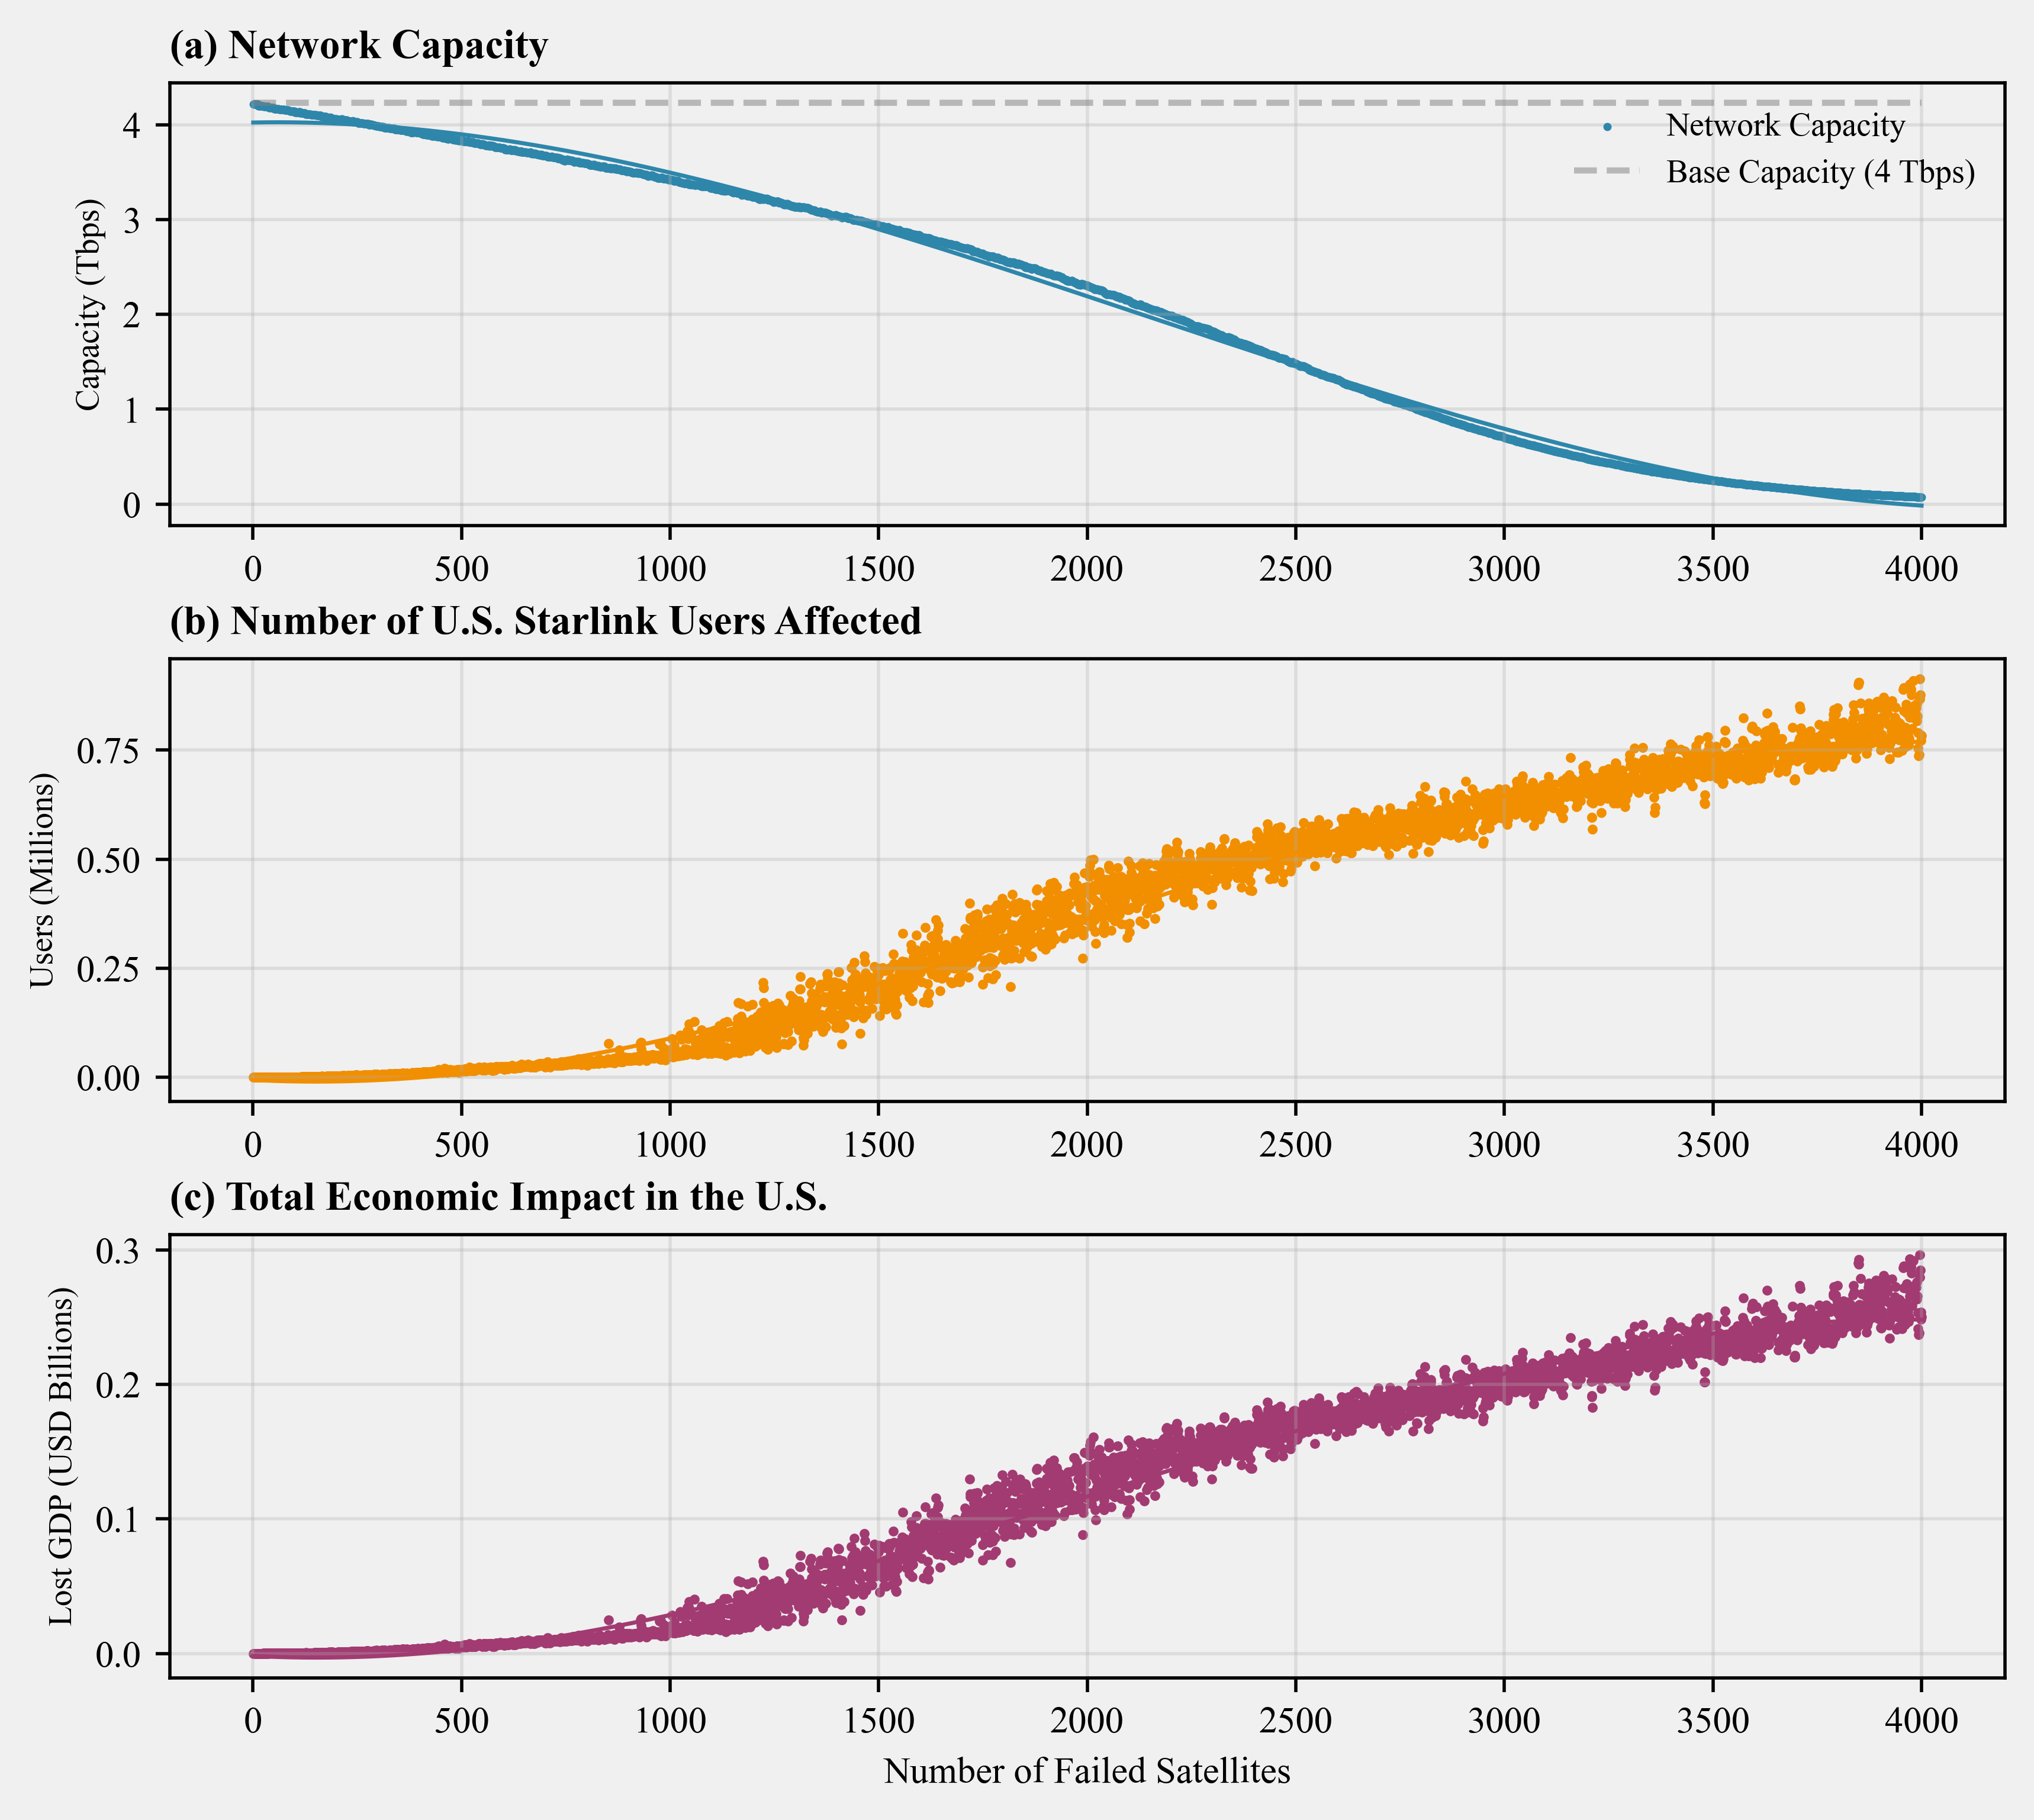

In [53]:
# Extract metrics and sort satellites
satellites = sorted(monte_carlo_results.keys())
capacity = [monte_carlo_results_c[n_failed]['capacity_gbps']['mean'] for n_failed in satellites] 
base_capacity = initial_total_capacity * np.ones_like(satellites)
users = [monte_carlo_results[n_failed]['starlink_users_affected']['mean'] / 1e6 for n_failed in satellites]
gdp_impact = [monte_carlo_results[n_failed]['total_economic_impact']['mean'] / 1e6 for n_failed in satellites]

# Create figure with 3 subplots
fig = plt.figure(figsize=(8, 7), dpi=500)
plt.rcParams.update({'font.size': 10})
gs = GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.3)

# Set background colors
fig.patch.set_facecolor('#f0f0f0')
for i in range(3):
   ax = fig.add_subplot(gs[i])
   ax.set_facecolor('#f0f0f0')
   if i > 0:
       ax.sharex(fig.axes[0])
ax1, ax2, ax3 = fig.axes

# Plot network capacity
ax1.scatter(satellites, [c/1000 for c in capacity], color='#2E86AB', s=1, label='Network Capacity')
z1 = np.polyfit(satellites, [c/1000 for c in capacity], 3)
p1 = np.poly1d(z1)
ax1.plot(satellites, p1(satellites), color='#2E86AB', linewidth=1)
ax1.plot(satellites, base_capacity/1000, '--', color='gray', alpha=0.5, 
        label=f'Base Capacity ({base_capacity[0]/1000:.0f} Tbps)')

# Plot affected users 
ax2.scatter(satellites, users, color='#F18F01', s=2, label='Affected Users')
z2 = np.polyfit(satellites, users, 3)
p2 = np.poly1d(z2)
ax2.plot(satellites, p2(satellites), color='#F18F01', linewidth=1)

# Plot GDP impact
ax3.scatter(satellites, gdp_impact, color='#A23B72', s=2, label='GDP Impact')
z3 = np.polyfit(satellites, gdp_impact, 3)
p3 = np.poly1d(z3)
ax3.plot(satellites, p3(satellites), color='#A23B72', linewidth=1)

# Configure plots and grids
for ax in [ax1, ax2, ax3]:
   ax.grid(True, which='major', linestyle='-', alpha=0.3, zorder=0)
   ax.grid(True, which='minor', linestyle='--', alpha=0.15, zorder=0)
   ax.tick_params(labelsize=9)

# Set titles and labels with scientific notation
ax1.set_title("(a) Network Capacity", fontsize=10, fontweight="bold", loc="left")
ax1.set_ylabel(r"Capacity (Tbps)", fontsize=8)

ax2.set_title("(b) Number of U.S. Starlink Users Affected", fontsize=10, fontweight="bold", loc="left")
ax2.set_ylabel(r"Users (Millions)", fontsize=8)

ax3.set_title("(c) Total Economic Impact in the U.S.", fontsize=10, fontweight="bold", loc="left")
ax3.set_ylabel(r"Lost GDP (USD Billions)", fontsize=8)
ax3.set_xlabel("Number of Failed Satellites", fontsize=9)

ax1.legend(frameon=False, loc='upper right', fontsize=8)
plt.tight_layout()

fig.savefig("figures/starlink_impact.png", dpi=300, bbox_inches='tight',
           facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()